In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler

# Divide data by displacement reason

In [3]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv")
#df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
pop_density = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/population_density.csv")
pop_density['admin1'] = pop_density['admin1'].str.replace('_',' ')
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')
inv_distance = 1/distance
df_d=pd.merge(df_d,pop_density,how='left',on=['year','admin1'],suffixes=('_norm', ''))
df_d = df_d.drop(['Awdal_x', 'Bakool_x', 'Banadir_x', 'Bari_x', 'Bay_x', 'Galgaduud_x',
       'Gedo_x', 'Hiraan_x', 'Lower_Juba_x', 'Lower_Shabelle_x',
       'Middle_Juba_x', 'Middle_Shabelle_x', 'Mudug_x', 'Nugaal_x', 'Sanaag_x',
       'Sool_x', 'Togdheer_x', 'Woqooyi_Galbeed_x', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'month_name','Awdal_y',
       'Bakool_y', 'Banadir_y', 'Bari_y', 'Bay_y', 'Galgaduud_y', 'Gedo_y',
       'Hiraan_y', 'Lower_Juba_y', 'Lower_Shabelle_y', 'Middle_Juba_y',
       'Middle_Shabelle_y', 'Mudug_y', 'Nugaal_y', 'Sanaag_y', 'Sool_y',
       'Togdheer_y', 'Woqooyi_Galbeed_y'], axis=1)

In [4]:
disp_data_d = disp_data[(disp_data['Reason']=='Drought related')]
disp_data_f = disp_data[(disp_data['Reason']=='Flood')]
disp_data_fd = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
disp_data_c = disp_data[(disp_data['Reason']=='Conflict/Insecurity')]

agg_r=np.empty(4, dtype=object)
agg_d=np.empty(4, dtype=object)
disp_matxs_r=np.empty(4, dtype=object)
disp_matxs_d=np.empty(4, dtype=object)
agg_r_22, agg_d_22, disp_matxs_r_22, disp_matxs_d_22 = np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)
agg_r_17, agg_d_17, disp_matxs_r_17, disp_matxs_d_17 =np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)
agg_r_20, agg_d_20, disp_matxs_r_20, disp_matxs_d_20 =np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)
agg_r_21, agg_d_21, disp_matxs_r_21, disp_matxs_d_21 =np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)

for i,dd in enumerate([disp_data_d, disp_data_f, disp_data_fd, disp_data_c]):
    v= dd["Month End"]
    v=v.values
    dt = [datetime.strptime(v[j], "%d/%m/%Y") for j in range(len(v))]
    q=[]
    for j in range(len(dt)):
        q.append(datetime.timestamp(dt[j])) 
    dd.insert(loc=3, column='date_timestamp', value=q)
    dd=dd.sort_values("date_timestamp")
    dd['Month End'] = pd.to_datetime(dd['Month End'], dayfirst=True)

    #aggregate by region

    aggregated_data = dd.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()
    dates = aggregated_data.index.get_level_values('Month End').unique()
    regions = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
    all_combinations = pd.MultiIndex.from_product([dates, regions, regions], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])
    agg_r[i] = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

    disp_matxs_r[i] = agg_r[i].pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
    disp_matxs_r[i]['year'] = disp_matxs_r[i].index.get_level_values('time').year

    #aggregate by district

    aggregated_data = dd.groupby([pd.Grouper(key='Month End', freq='M'), 'Previous (Departure) District', 'Current (Arrival) District']).agg({'Number of Individuals': 'sum', 'Current (Arrival) Region': 'first', 'Previous (Departure) Region': 'first'})
    dates = aggregated_data.index.get_level_values('Month End').unique()
    districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
    all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
    agg_d[i] = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

    disp_matxs_d[i] = agg_d[i].pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
    disp_matxs_d[i]['year'] = disp_matxs_d[i].index.get_level_values('time').year

    #subset the data
    agg_r_17[i] = agg_r[i][agg_r[i]['time'].dt.year==2017]
    agg_d_17[i] = agg_d[i][agg_d[i]['time'].dt.year==2017]
    disp_matxs_r_17[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2017]
    disp_matxs_d_17[i] = disp_matxs_d[i][disp_matxs_d[i]['year']==2017]

    agg_r_20[i] = agg_r[i][agg_r[i]['time'].dt.year==2020]
    agg_d_20[i] = agg_d[i][agg_d[i]['time'].dt.year==2020]
    disp_matxs_r_20[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2020]
    disp_matxs_d_20[i] = disp_matxs_d[i][disp_matxs_d[i]['year']==2020]

    agg_r_21[i] = agg_r[i][agg_r[i]['time'].dt.year==2021]
    agg_d_21[i] = agg_d[i][agg_d[i]['time'].dt.year==2021]
    disp_matxs_r_21[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2021]
    disp_matxs_d_21[i] = disp_matxs_d[i][disp_matxs_d[i]['year']==2021]

    agg_r_22[i] = agg_r[i][agg_r[i]['time'].dt.year==2022]
    agg_d_22[i] = agg_d[i][agg_d[i]['time'].dt.year==2022]
    disp_matxs_r_22[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2022]
    disp_matxs_d_22[i] = disp_matxs_d[i][disp_matxs_d[i]['year']==2022]

In [5]:
# to dictionary

agg_r = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r))
agg_d = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d))
disp_matxs_r = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r))
disp_matxs_d = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d))
disp_matxs_r_22 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_22))
disp_matxs_d_22 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d_22))
agg_r_22 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_22))
agg_d_22 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d_22))

disp_matxs_r_17 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_17))
disp_matxs_d_17 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d_17))
agg_r_17 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_17))
agg_d_17 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d_17))

disp_matxs_r_20 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_20))
disp_matxs_d_20 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d_20))
agg_r_20 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_20))
agg_d_20 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d_20))

disp_matxs_r_21 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_21))
disp_matxs_d_21 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d_21))
agg_r_21 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_21))
agg_d_21 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d_21))


In [6]:
df_d_17 = df_d[df_d['year']==2017]
df_d_20 = df_d[df_d['year']==2020]
df_d_21 = df_d[df_d['year']==2021]
df_d_22 = df_d[df_d['year']==2022]

In [7]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']
lag_str = ['TA', 'TA_{lag1}', 'TA_{lag2}', 'TA_{lag3}', 'TA_{lag4}', 'TA_{lag5}']

/tmp/ipykernel_14734/2164771232.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


# Plots

## Drought, all years

### Scatter plot, all years

$$
Log(Disp_{ji}) = f(\frac{TA_{lag2, i}}{dist^2_{ji}})
$$


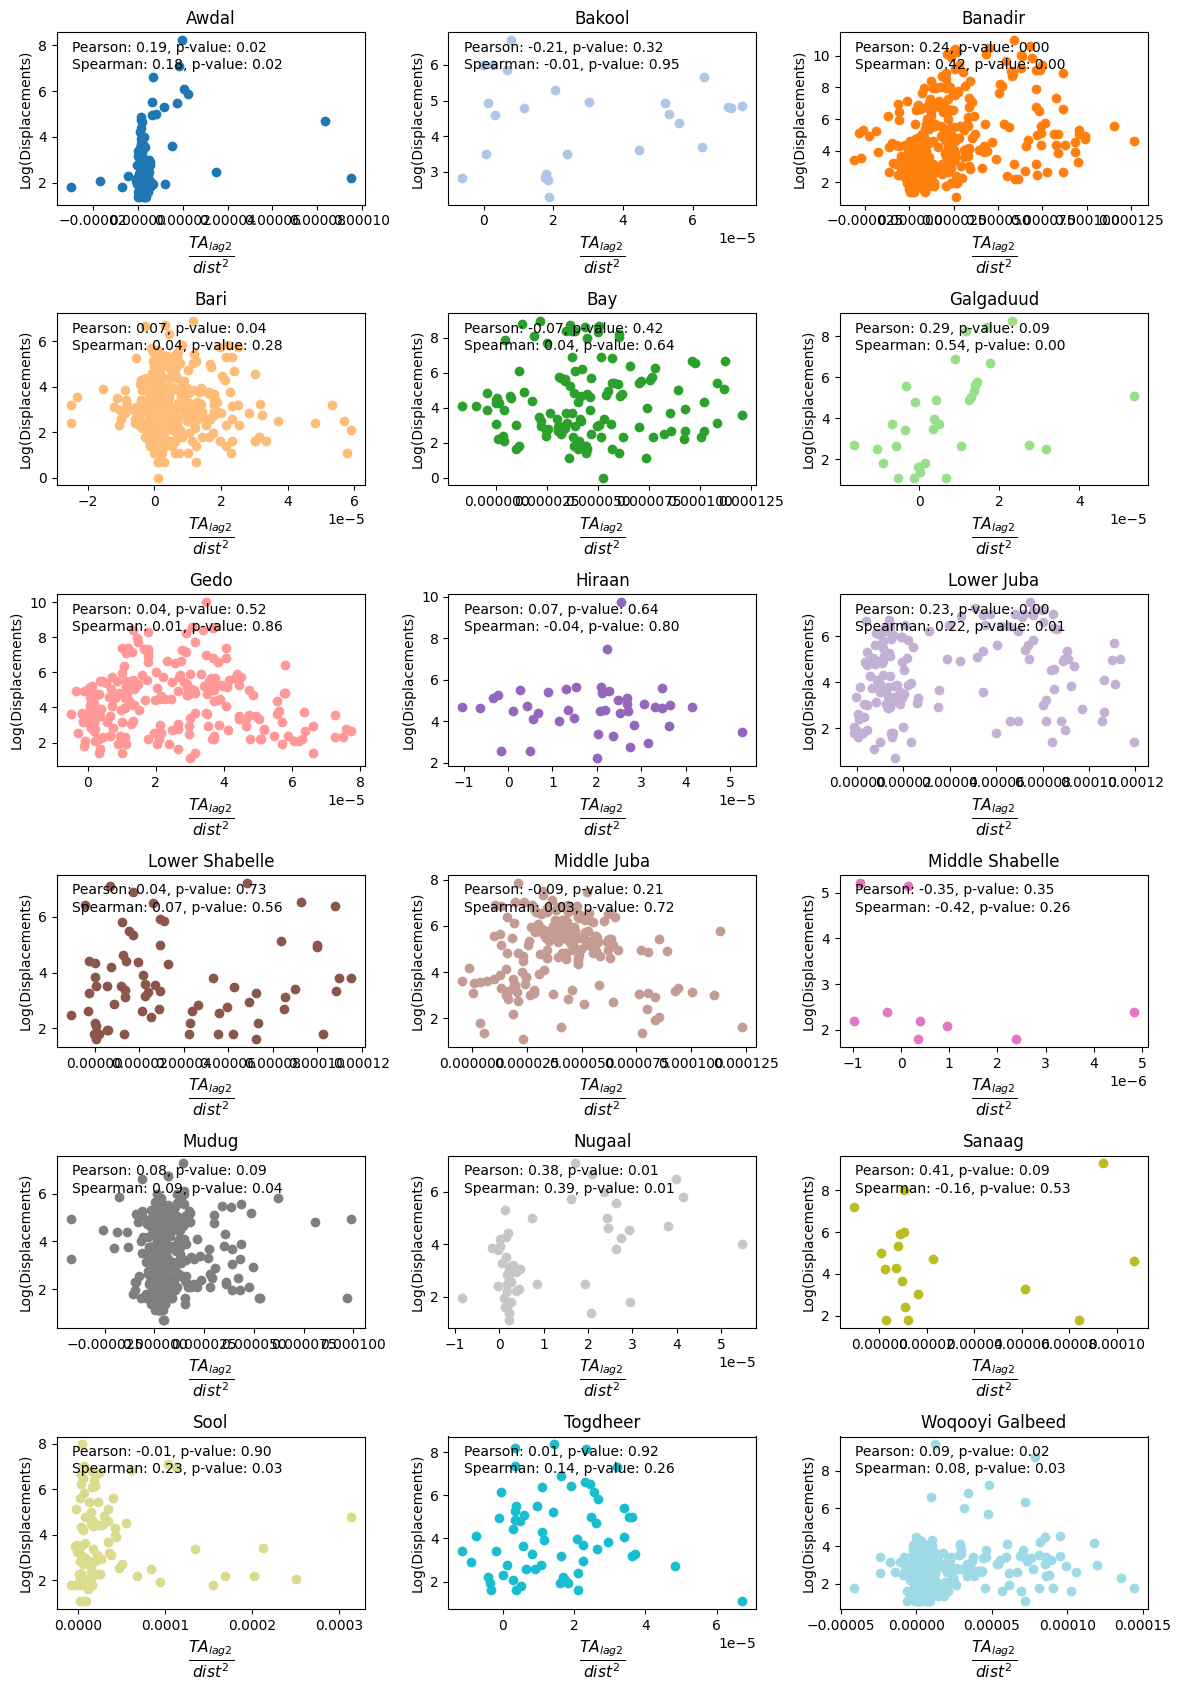

In [7]:
fig, axs = plt.subplots(6, 3, figsize=(12, 17))  

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['TA_lag2'] = df_m_y['TA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            color = cmap(region_codes[regions == j][0])
            axs[row, col].scatter(disp_reg['TA_lag2']*disp_reg['inv_dist']**2, np.log(disp_reg[j]), color=color)
        
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['inv_dist']*df_j['TA_lag2'])]
    df_j = df_j[df_j['inv_dist']*df_j['inv_dist']*df_j['TA_lag2'] != np.nan]

    
    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan

    axs[row, col].set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$', fontsize=16)
    axs[row, col].set_ylabel('Log(Displacements)')
    axs[row, col].set_title(j)
    axs[row, col].text(0.05, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    axs[row, col].text(0.05, 0.85, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    
plt.tight_layout()
plt.show()

### Heatmap Pearson and spearman coefficient, drought all years

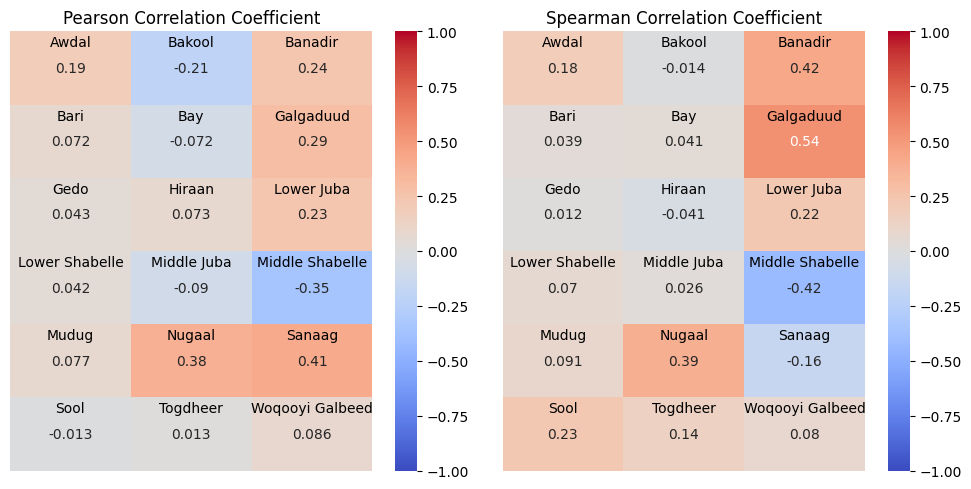

In [8]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
        
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['TA_lag2'] = df_m_y['TA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])

        vec_corr_pearson.append(corr_pearson)
        vec_corr_spearman.append(corr_spearman)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

### Heatmap Pearson and Spearman (lags), drought all years

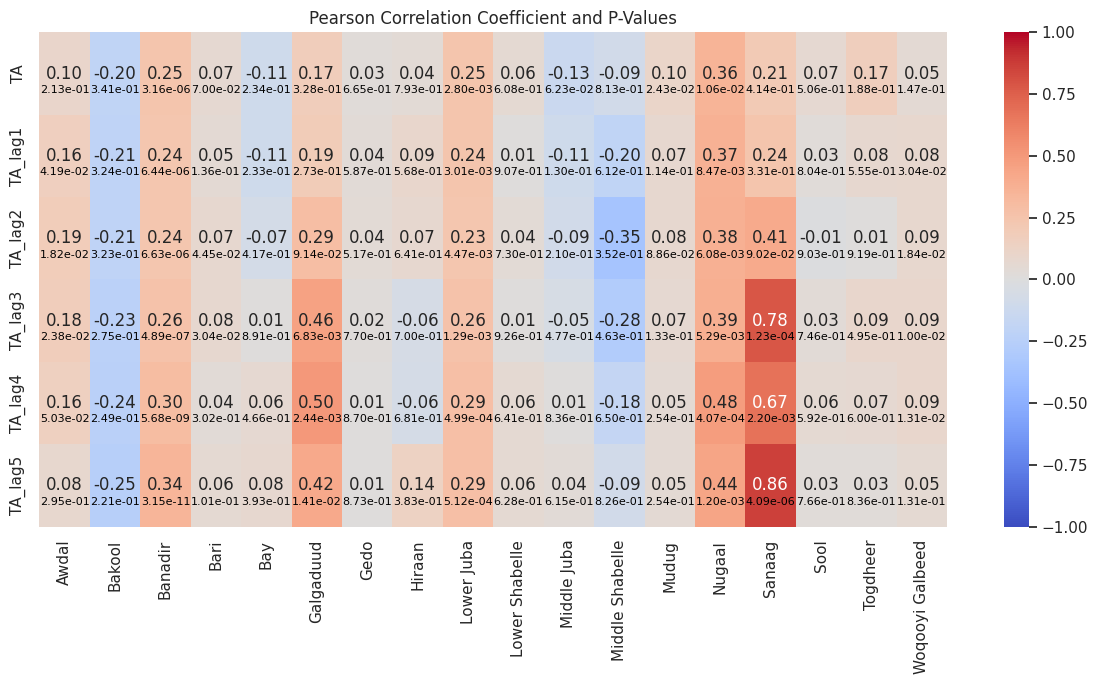

In [9]:
# Pearson coefficient heatmap

vec_corr_pearson = []
vec_p_values = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['TA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_corr_pearson.append(corr_pearson)
            vec_p_values.append(p_value)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)
vec_p_values = np.array(vec_p_values).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

# Add p-values to the heatmap
for i in range(vec_p_values.shape[0]):
    for j in range(vec_p_values.shape[1]):
        if not np.isnan(vec_p_values[i, j]):
            ax.text(j + 0.5, i + 0.7, f'{vec_p_values[i, j]:.2e}', ha='center', va='center', fontsize=8, color='black')

plt.title('Pearson Correlation Coefficient and P-Values')
plt.tight_layout()
plt.show()

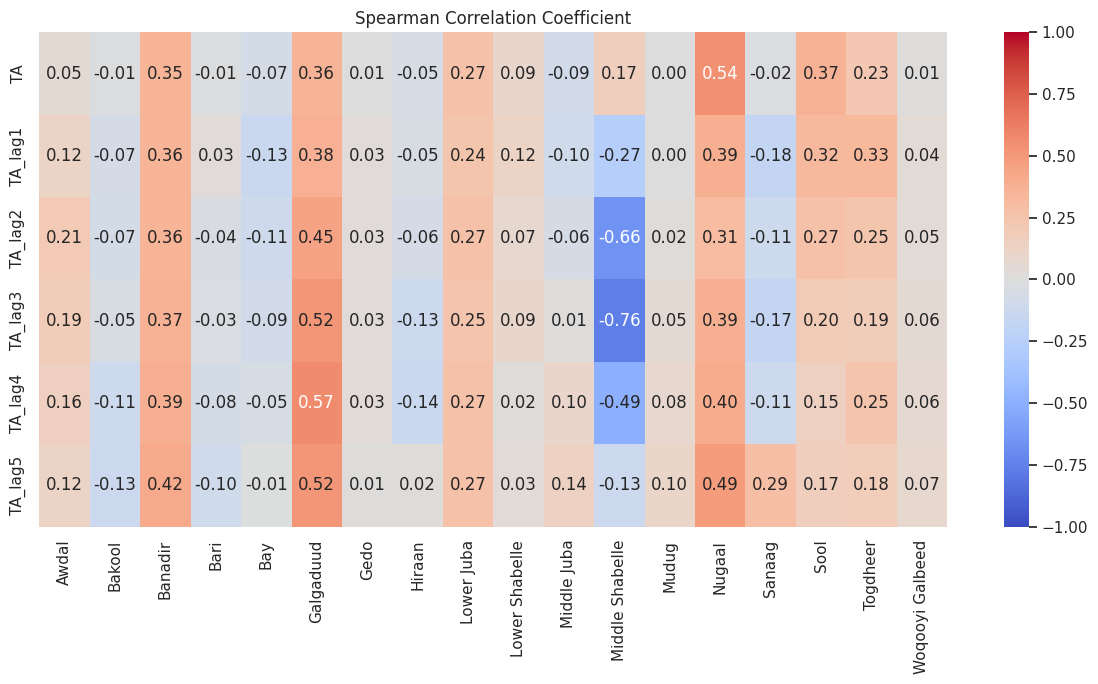

In [10]:
# Spearman coefficient heatmap

vec_corr_spearman = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
            
            for month in range(1, 13):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['TA_lag_n']*df_j['inv_dist']**2)]

        if len(df_j[j]) >= 2:
            corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['TA_lag_n'], df_j[j])
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_spearman.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)
#increase cell size
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()
plt.show()

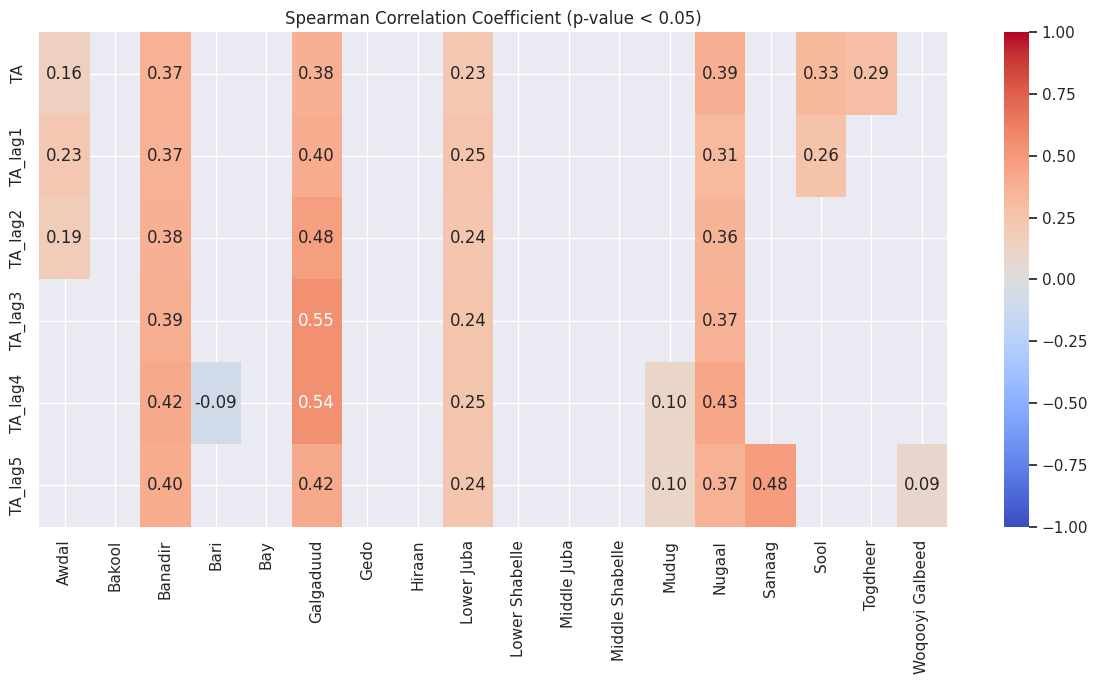

In [11]:
vec_corr_spearman = []
vec_p_values = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_spearman, p_value = spearmanr(df_j['inv_dist']*df_j['TA_lag_n'], df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_spearman.append(corr_spearman)
            else:
                vec_corr_spearman.append(np.nan)
        else:
            vec_corr_spearman.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Spearman Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

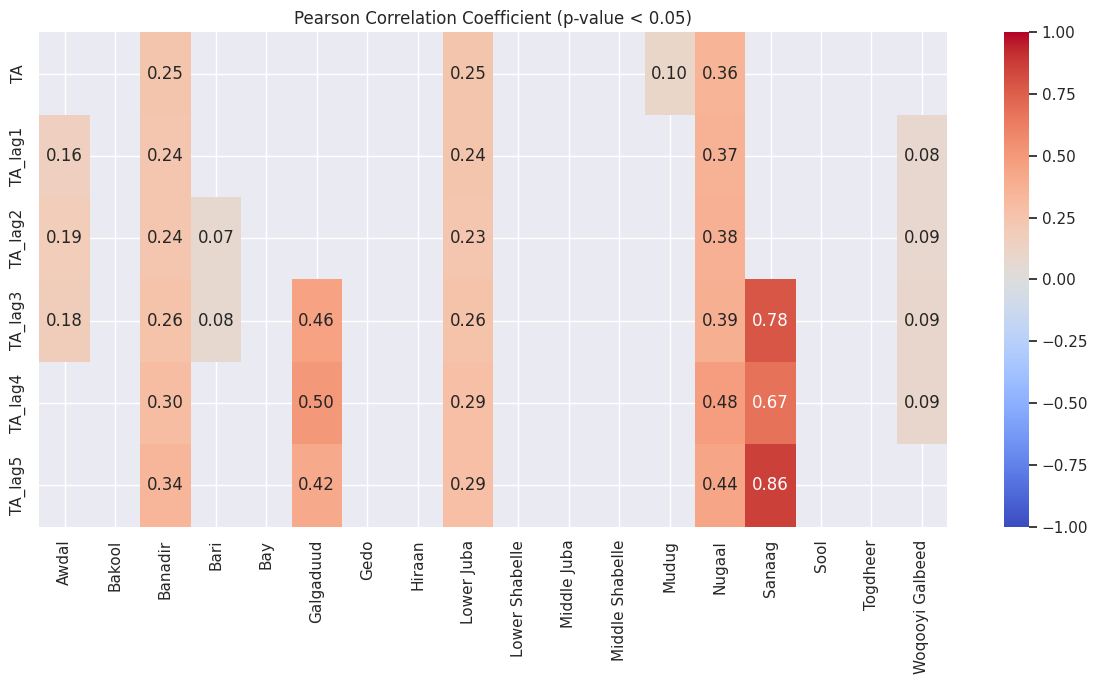

In [12]:
vec_corr_pearson = []
vec_p_values = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['TA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

## 2022 drought

### Time Series of Displacements to {destination} in 2022, due to drought

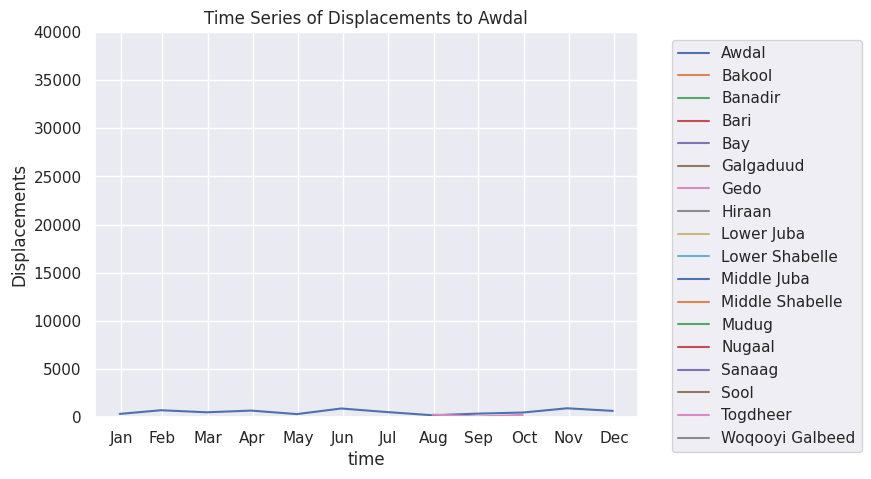

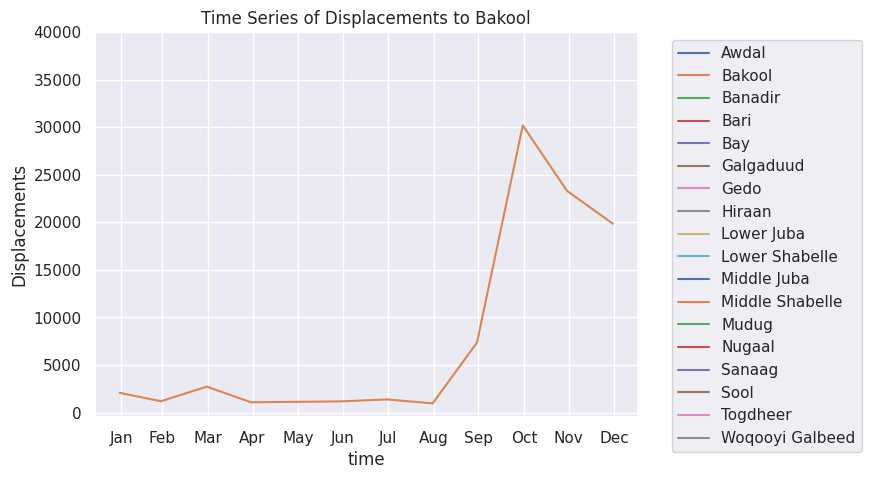

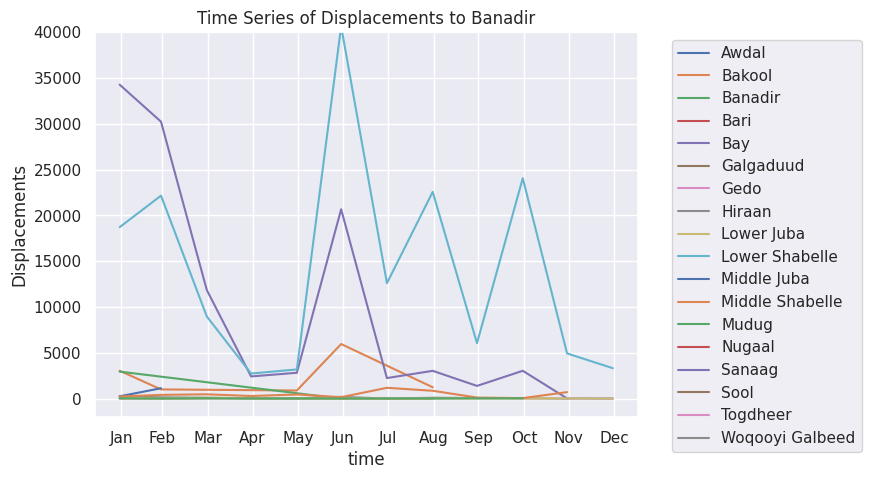

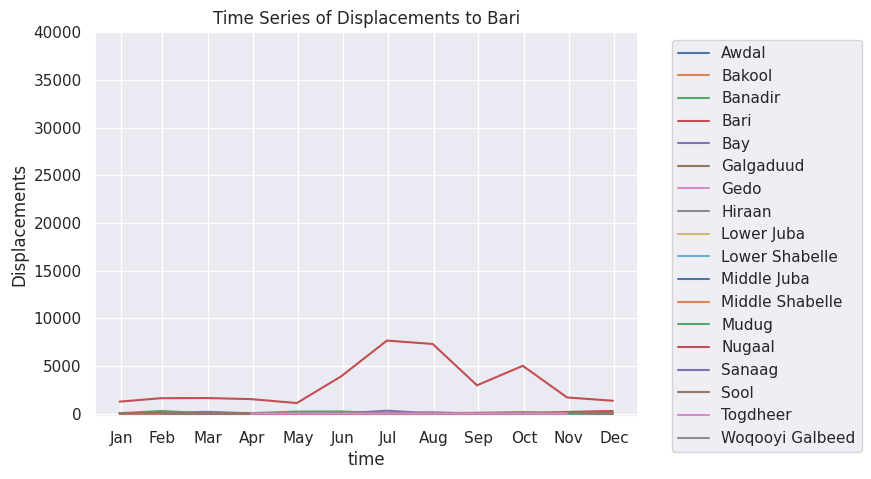

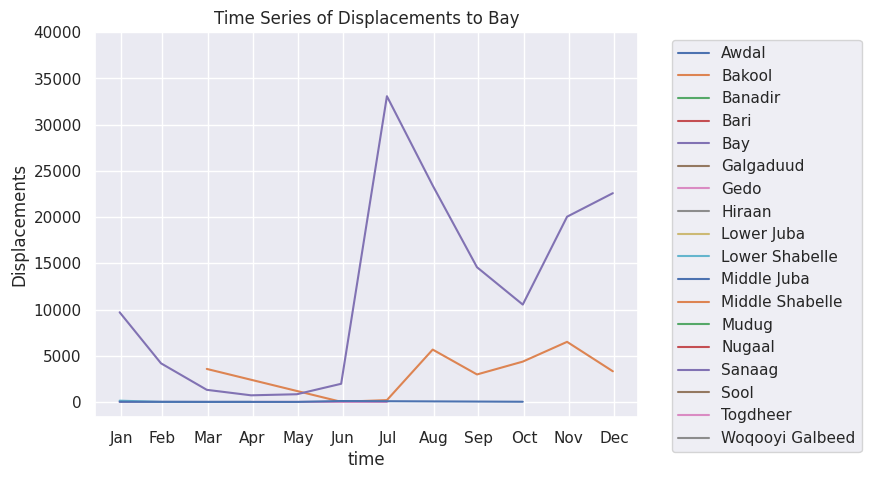

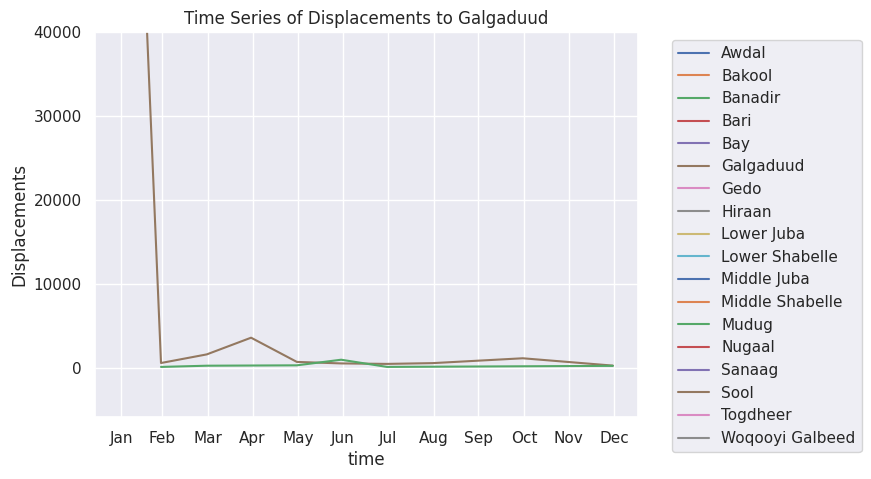

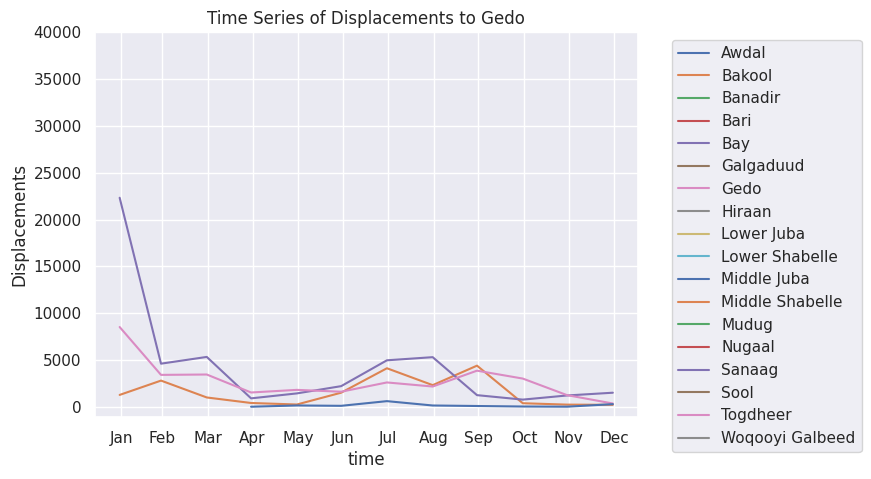

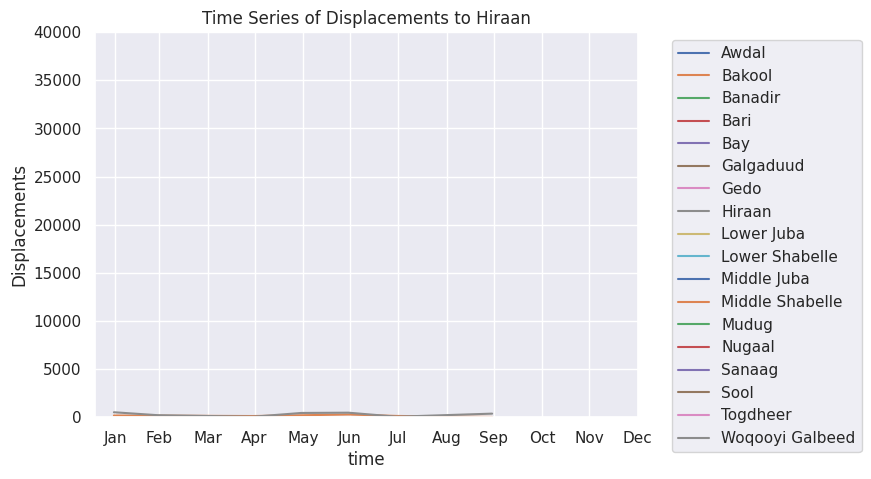

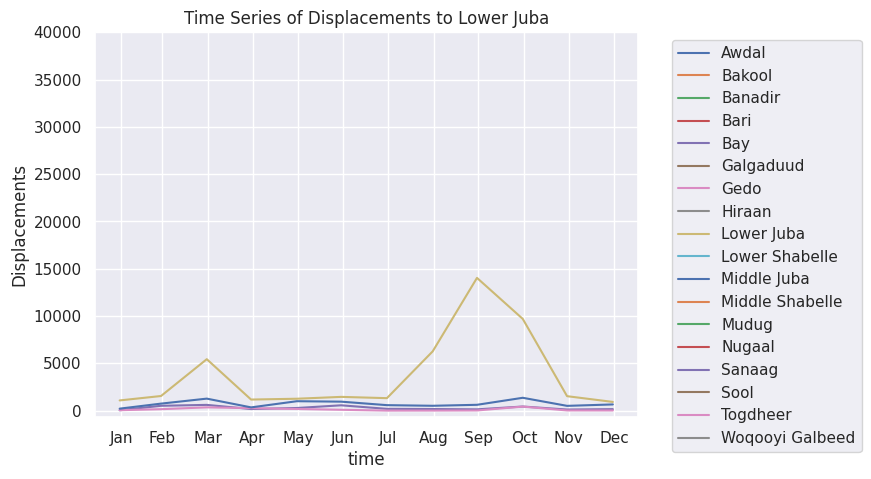

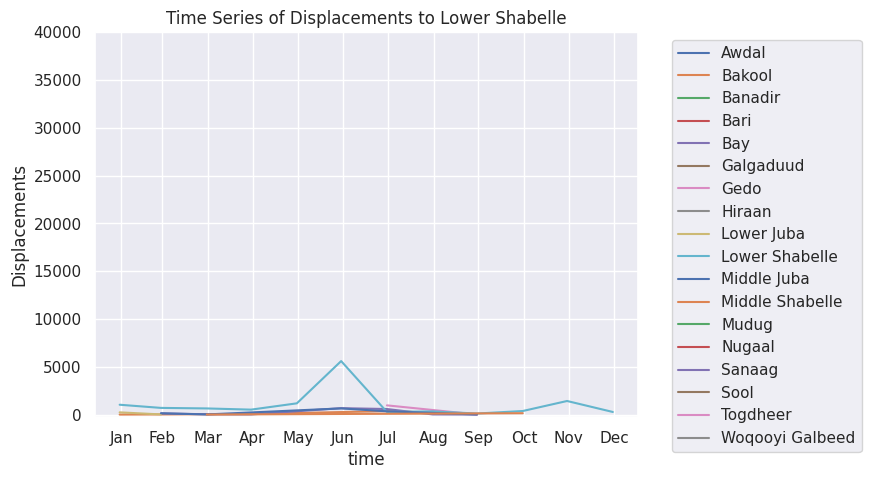

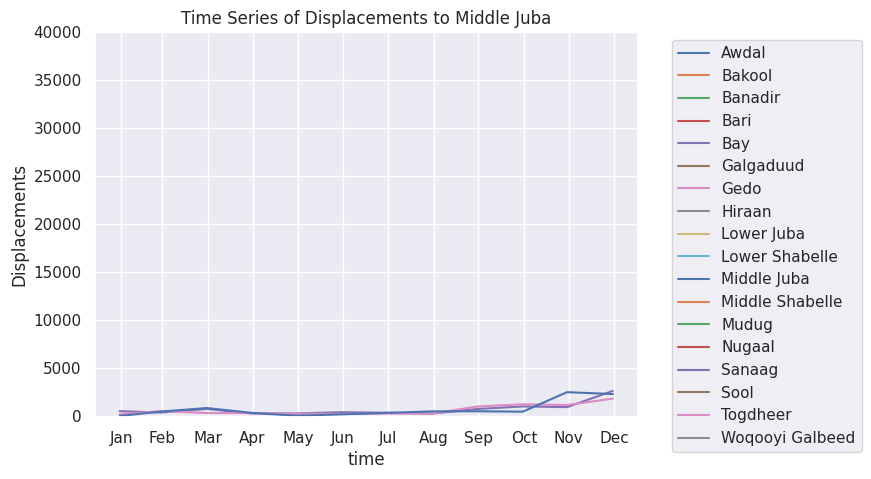

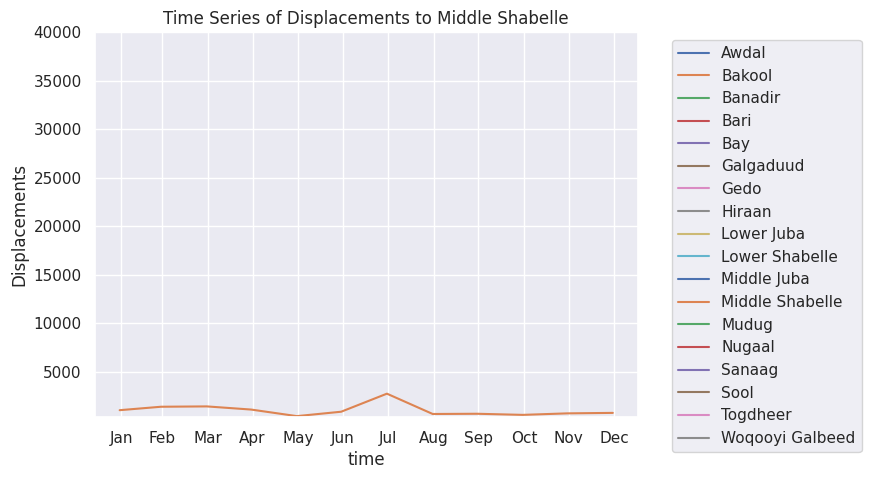

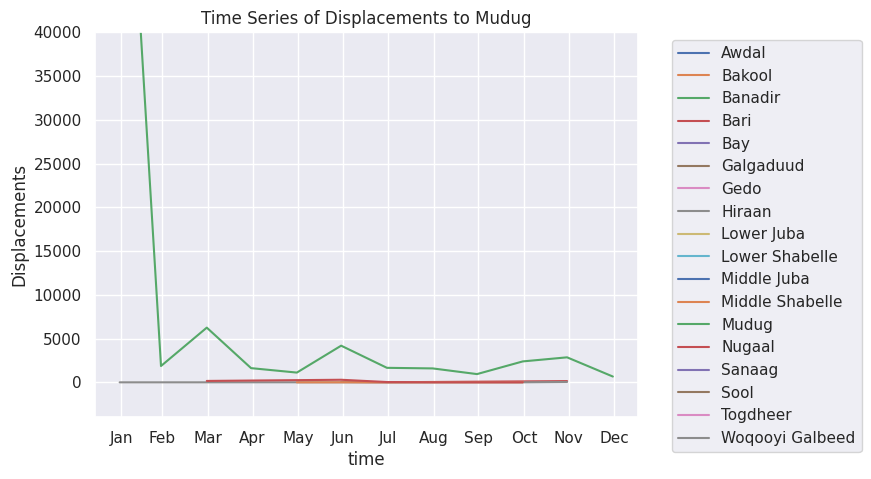

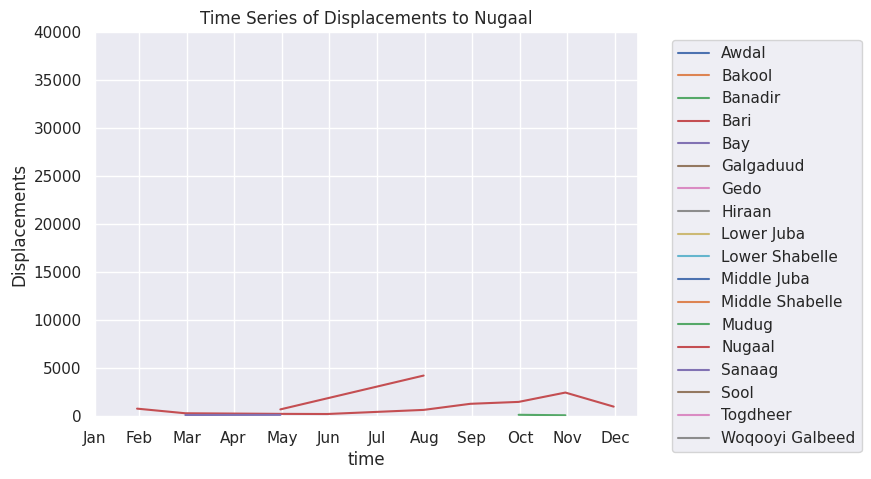

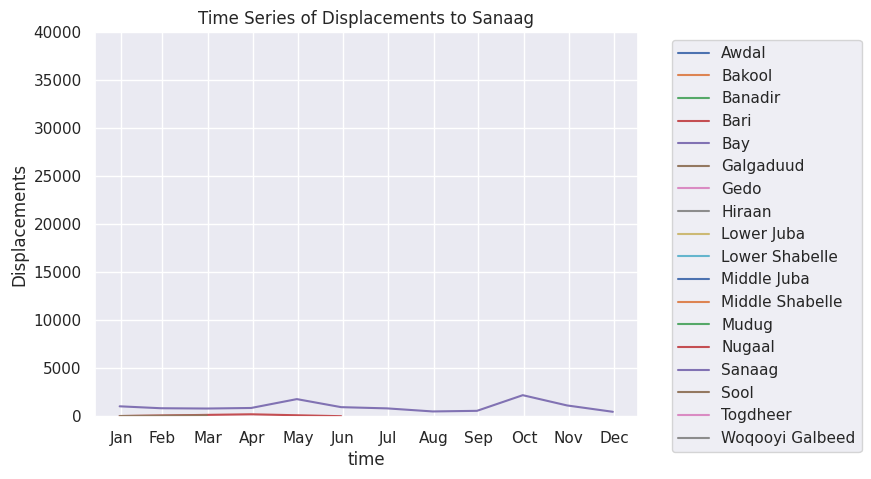

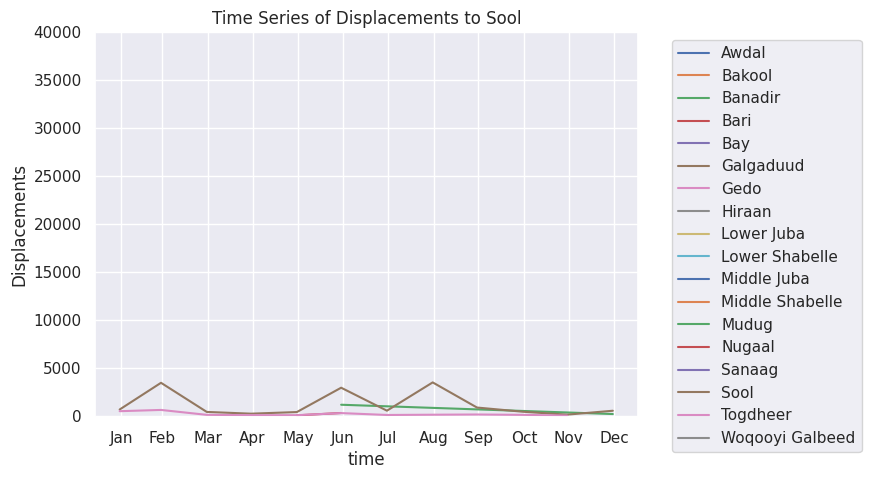

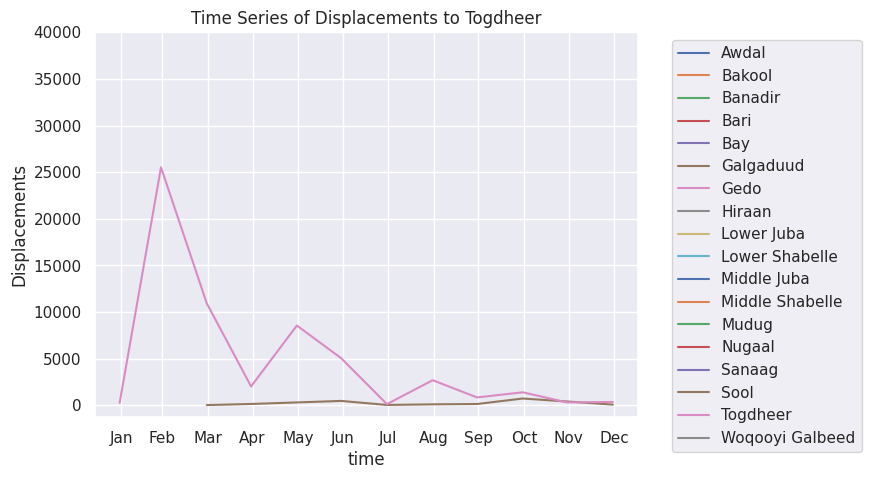

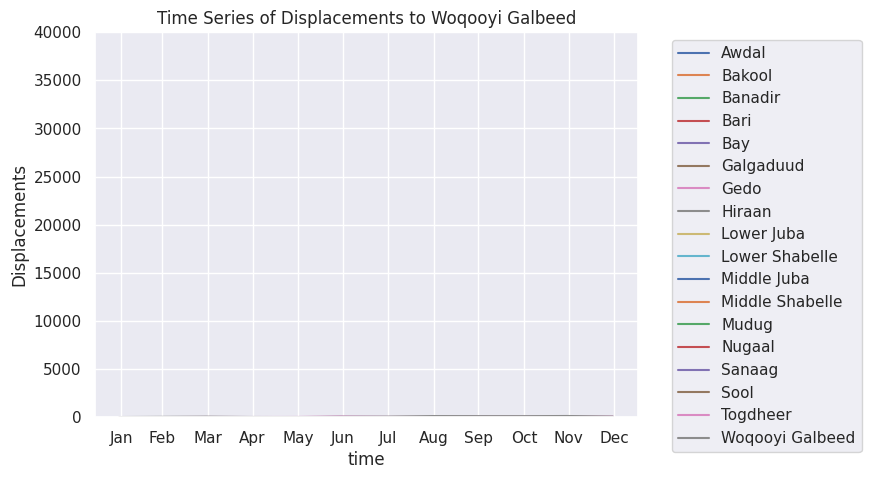

In [13]:
for destination in regions:
    
    # Filter the data for the specified region
    region_data = agg_d_22['drought'][agg_d_22['drought']['Current (Arrival) Region'] == destination]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(7, 5))

    # Iterate over each origin and plot the time series
    for origin in regions:

        region_data = region_data.groupby([pd.Grouper(key='time', freq='M'), 'Previous (Departure) Region']).agg({'Number of Individuals': 'sum', 'Current (Arrival) District': 'first', 'Previous (Departure) District': 'first'}).reset_index()
        origin_data = region_data[region_data['Previous (Departure) Region'] == origin]
        ax.plot(origin_data['time'], origin_data['Number of Individuals'], label=origin)

    # Set the title and labels
    ax.set_title(f"Time Series of Displacements to {destination}")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    ax.set_ylim(top=40000)
    ax.set_xticks([datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1), datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1), datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),datetime(2023, 1, 1), ])
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    # Set the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


### Time Series of Displacements to Galgaduud in 2022

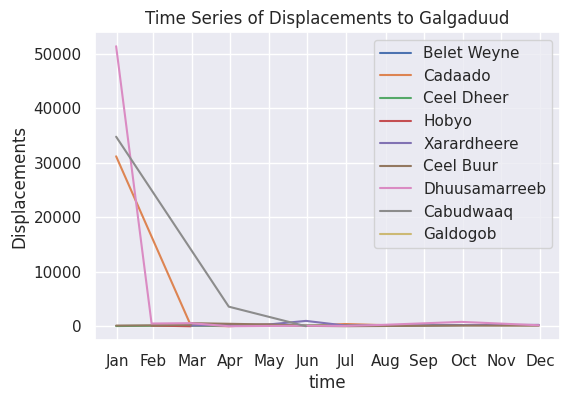

In [14]:
region_data = agg_d_22['drought'][agg_d_22['drought']['Current (Arrival) Region'] == 'Galgaduud']

# Plotting the time series
fig, ax = plt.subplots(figsize=(6, 4))

# Iterate over each origin and plot the time series
for origin in districts:
    origin_data = region_data[region_data['Previous (Departure) District'] == origin]
    if origin_data['Number of Individuals'].sum() > 0:
        ax.plot(origin_data['time'], origin_data['Number of Individuals'], label=origin)

# Set the title and labels
ax.set_title(f"Time Series of Displacements to Galgaduud")
ax.set_xticks([datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1), datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1), datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),datetime(2023, 1, 1), ])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel("time")
ax.set_ylabel("Displacements")
ax.legend()
plt.show()

### Time Series of drought Displacements from {origin} in 2022 with TA, PA

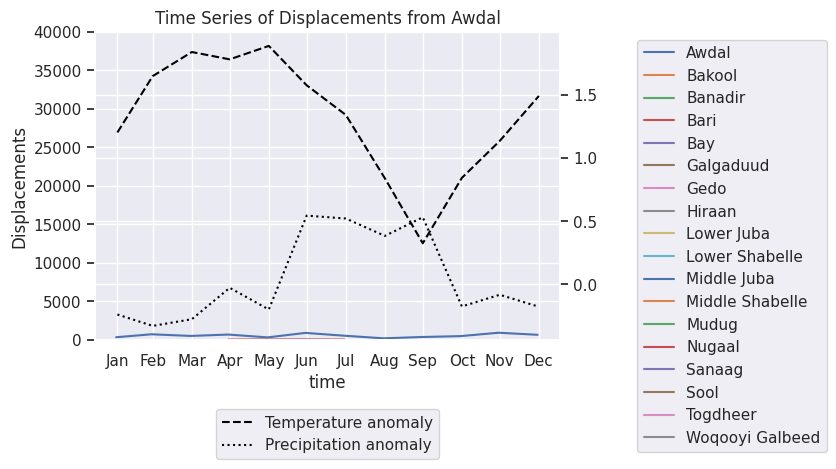

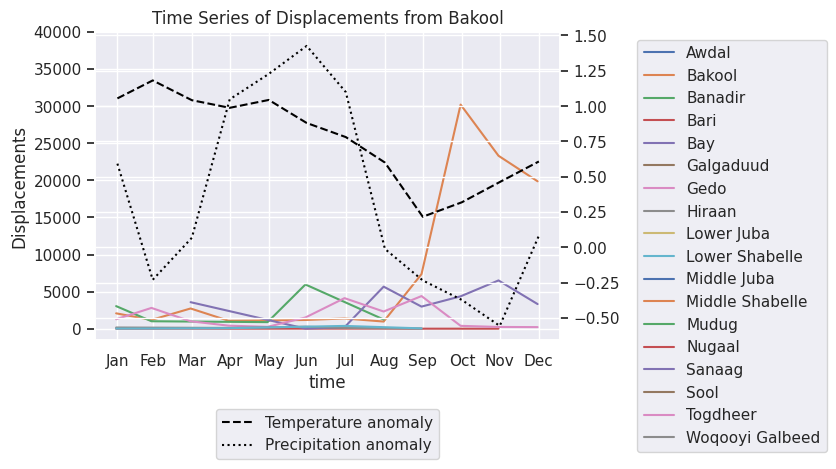

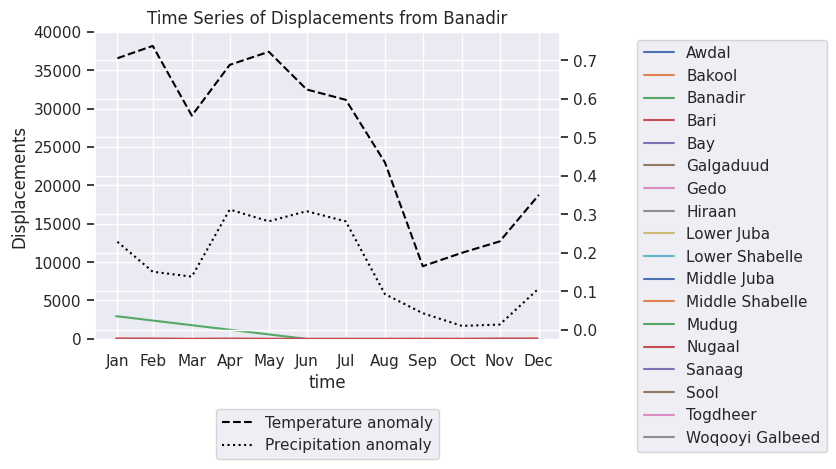

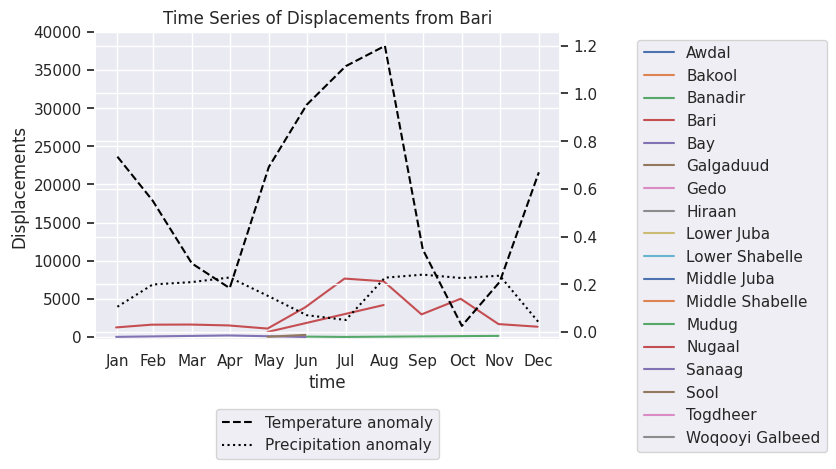

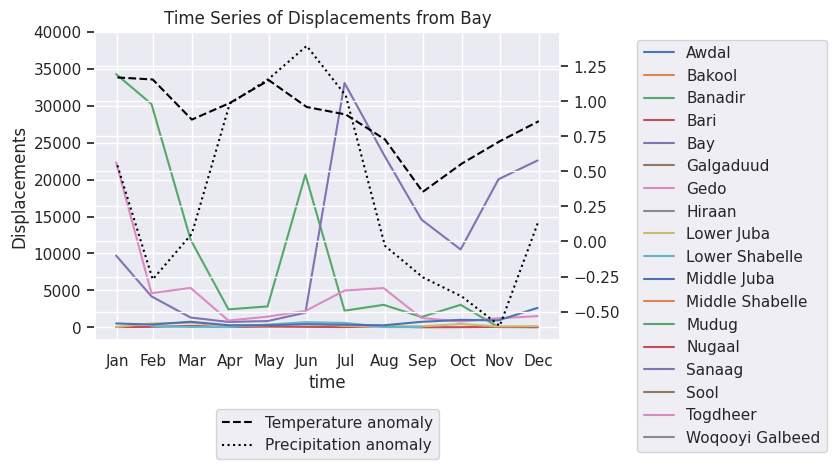

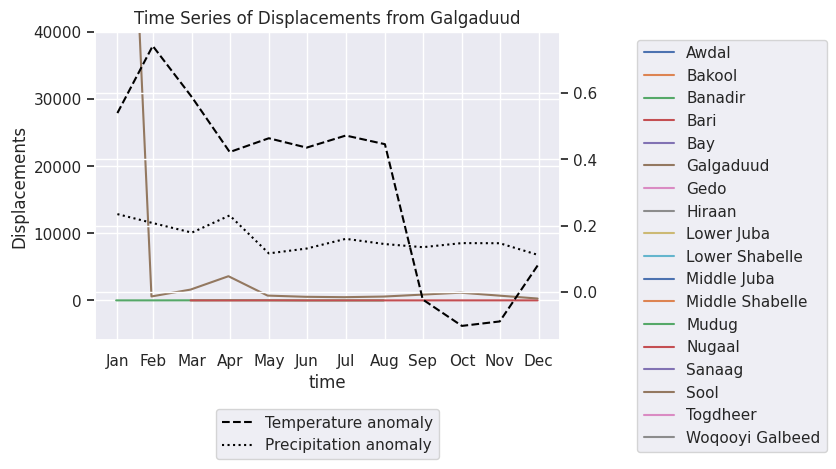

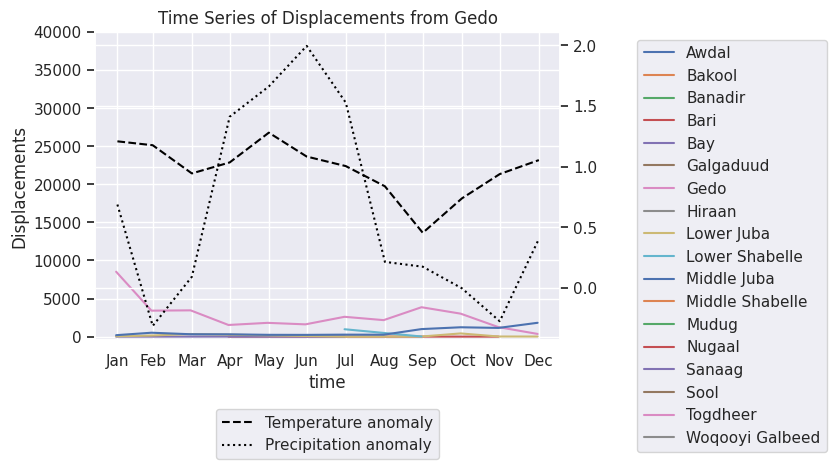

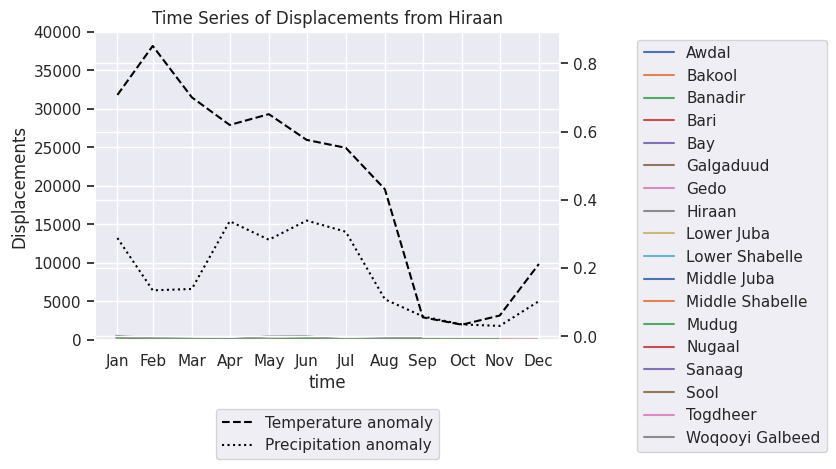

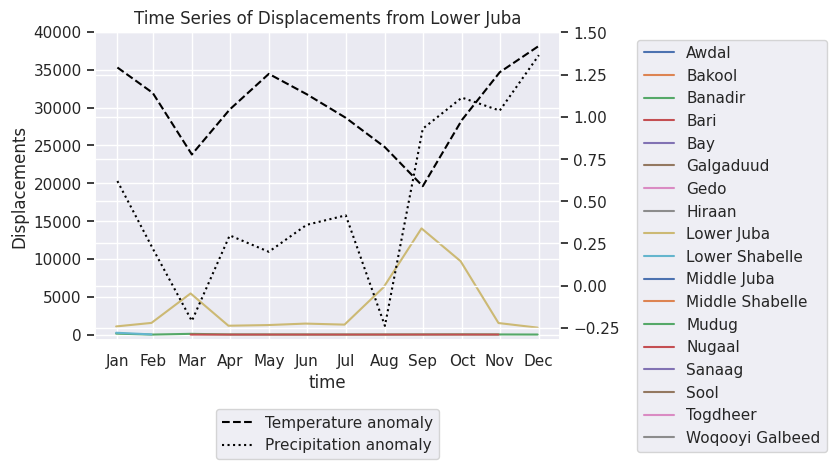

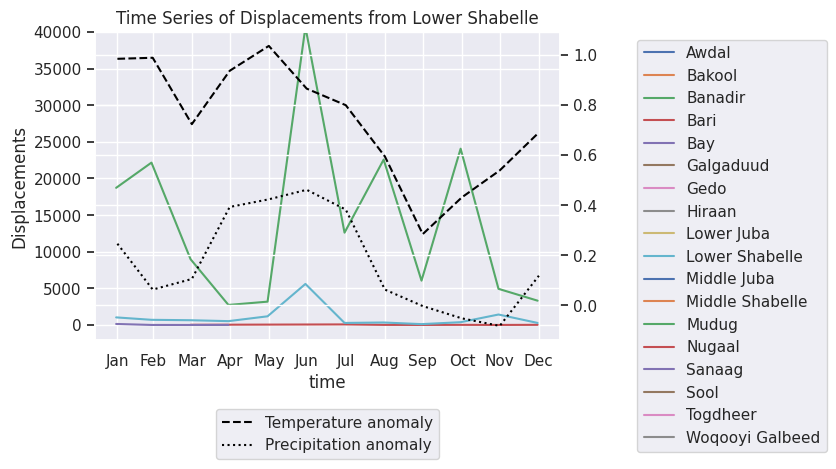

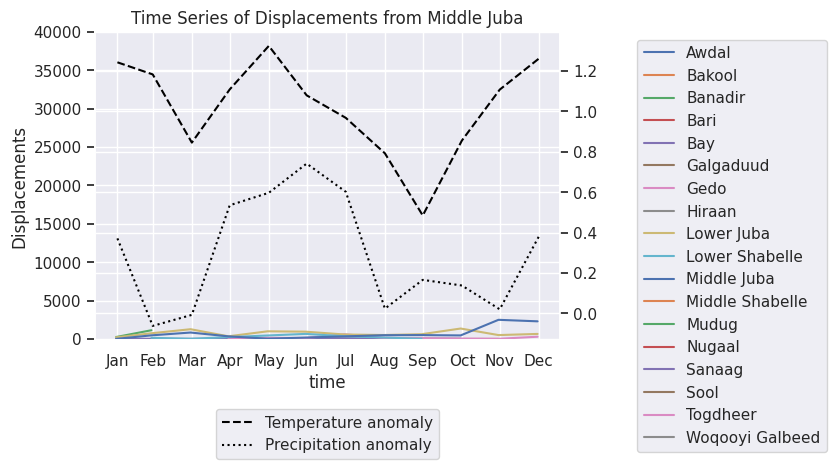

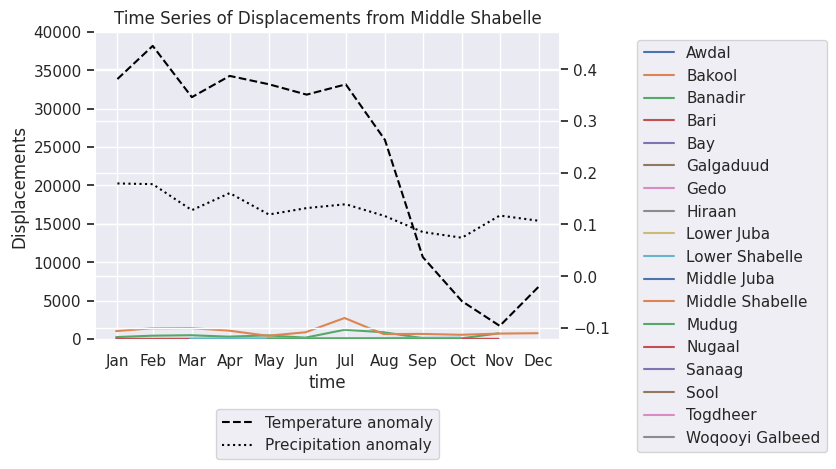

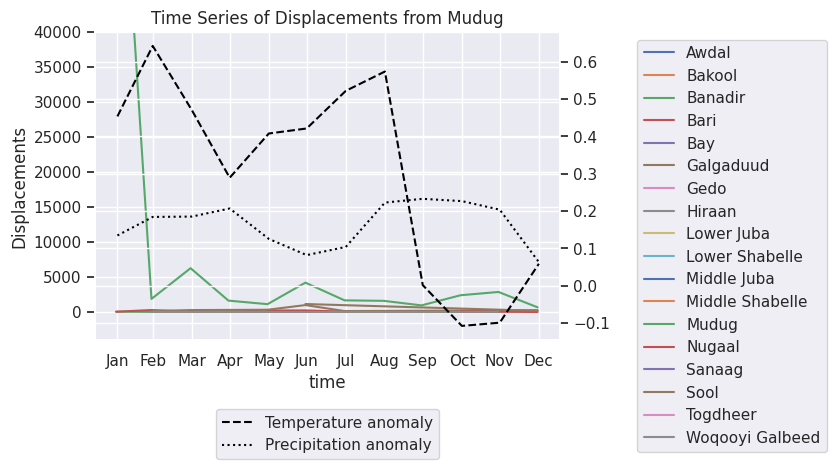

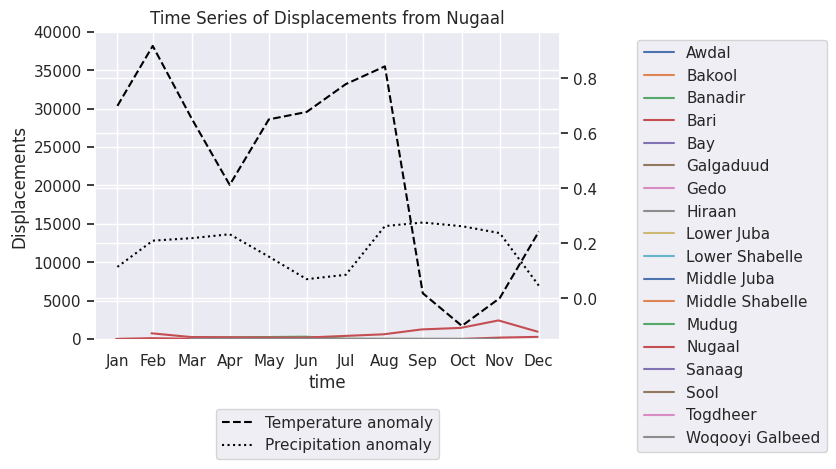

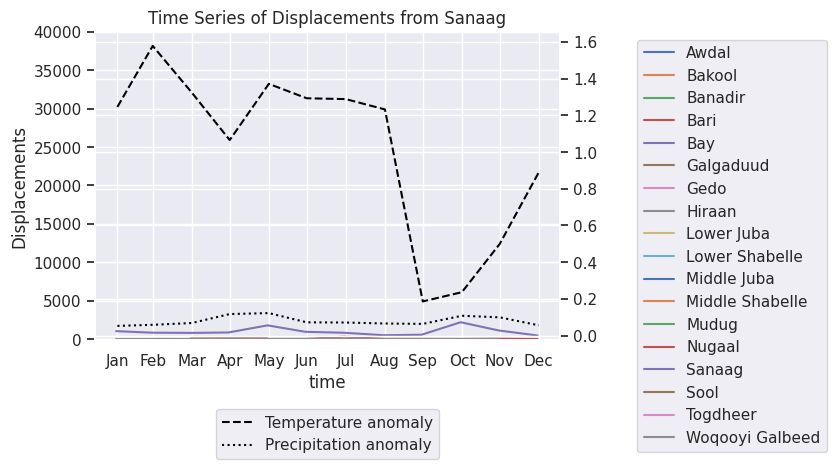

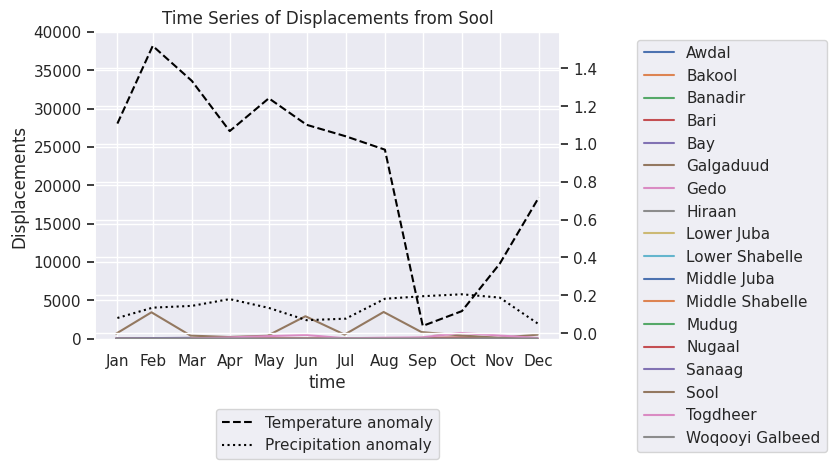

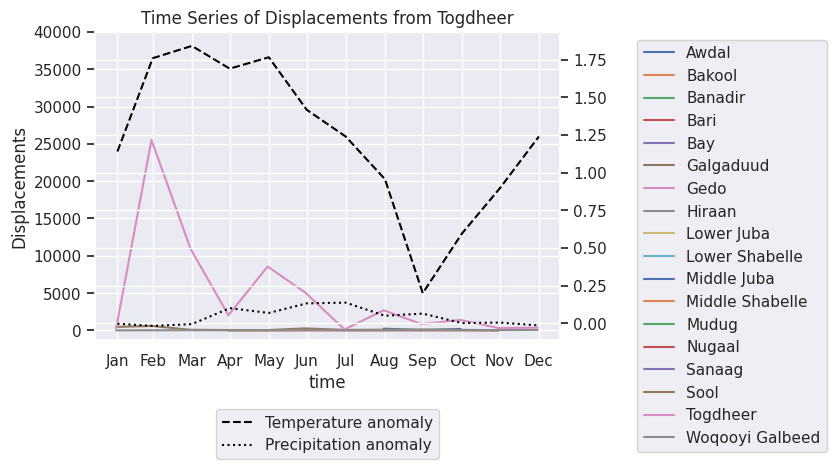

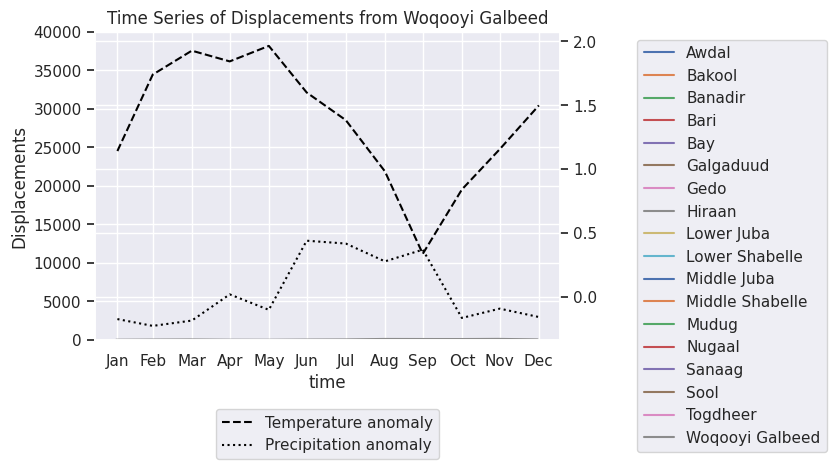

In [15]:
import warnings
warnings.filterwarnings('ignore')

for origin in regions:
    
    # Filter the data for the specified region
    region_data = agg_d_22['drought'][agg_d_22['drought']['Previous (Departure) Region'] == origin]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(6, 4))
    ax2 = ax.twinx()
    #ax3 = ax.twinx()

    # Iterate over each origin and plot the time series
    for destination in regions:
        
        region_data = region_data.groupby([pd.Grouper(key='time', freq='M'), 'Current (Arrival) Region']).agg({'Number of Individuals': 'sum', 'Current (Arrival) District': 'first', 'Previous (Departure) District': 'first'}).reset_index()
        destination_data = region_data[region_data['Current (Arrival) Region'] == destination]
        ax.plot(destination_data['time'], destination_data['Number of Individuals'], label=destination)
    ax2.plot(pd.to_datetime(df_d_22[df_d['admin1']==origin]['time'])+ pd.DateOffset(months=1), df_d_22[df_d['admin1']==origin]['TA'], color='black', linestyle='dashed', label='Temperature anomaly')
    ax2.plot(pd.to_datetime(df_d_22[df_d['admin1']==origin]['time'])+ pd.DateOffset(months=1), df_d_22[df_d['admin1']==origin]['PA'], color='black', linestyle='dotted', label='Precipitation anomaly')    

    # Set the title and labels
    ax.set_title(f"Time Series of Displacements from {origin}")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    ax.set_xticks([datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1), datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1), datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),datetime(2023, 1, 1), ])
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax.set_ylim(top=40000)
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
    ax2.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')
    plt.show()


### Time Series of total drought Displacements from {origin} in 2022 with TA, PA

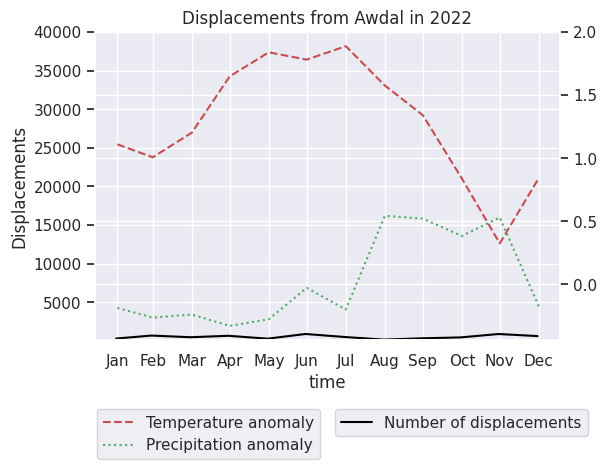

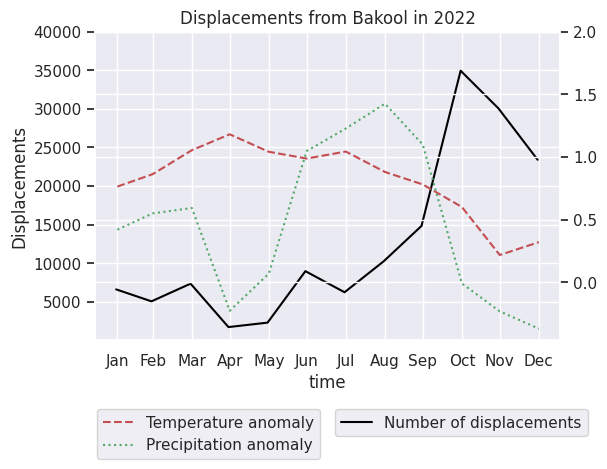

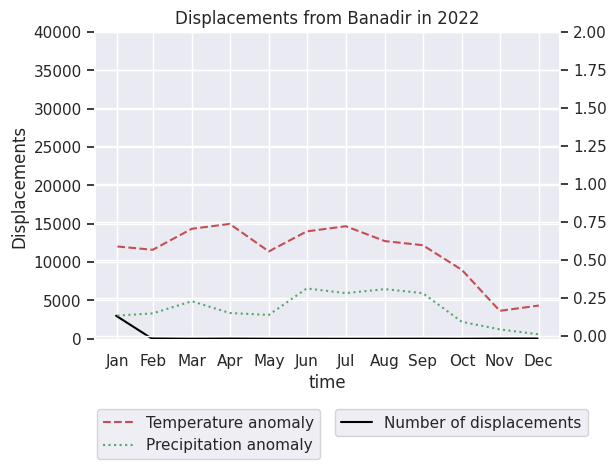

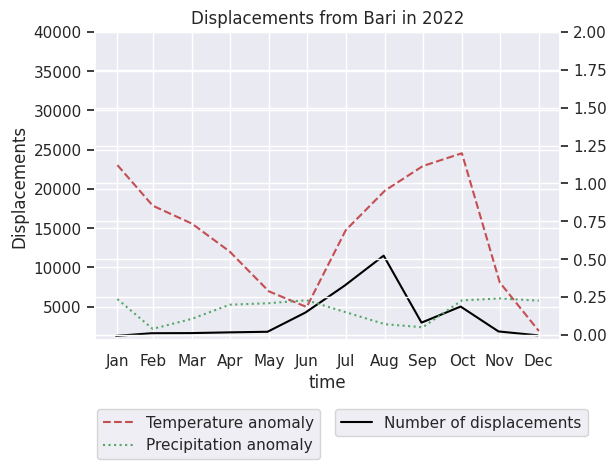

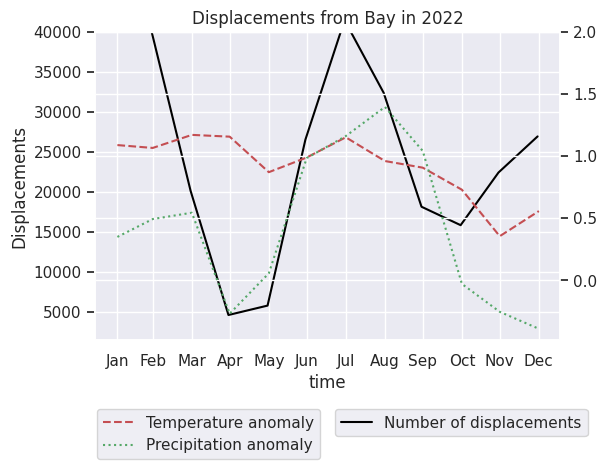

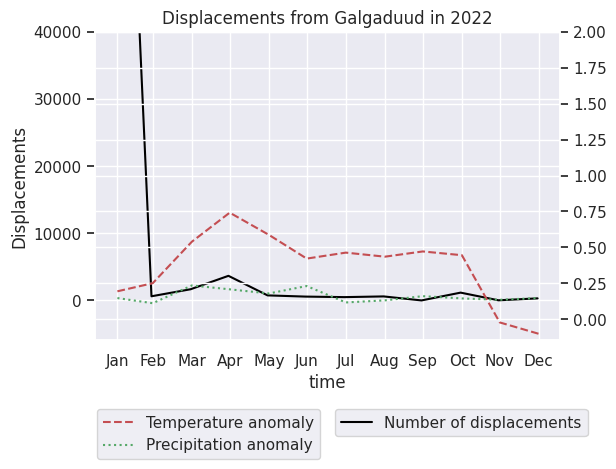

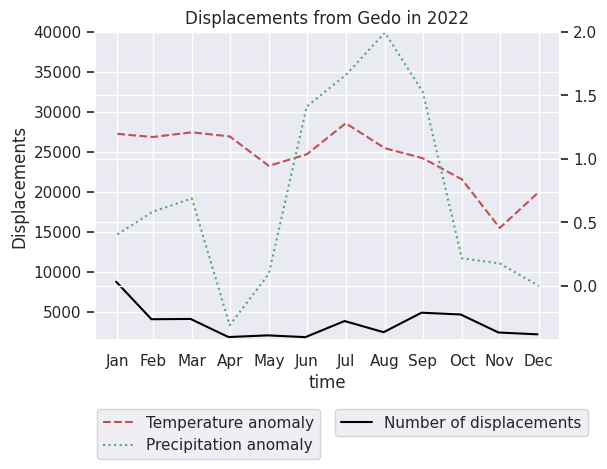

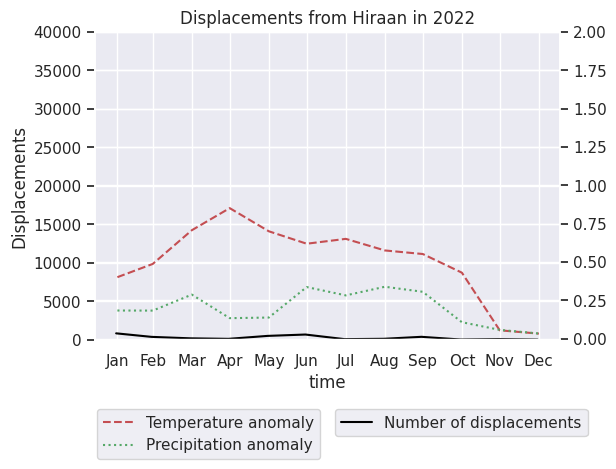

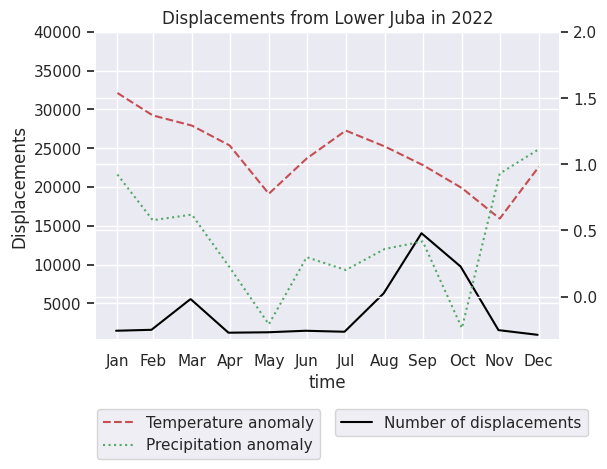

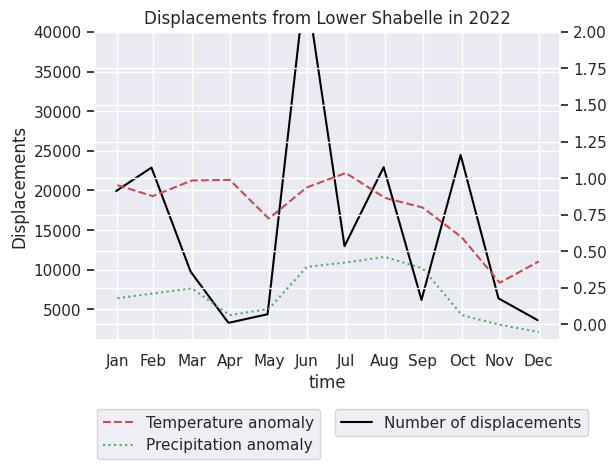

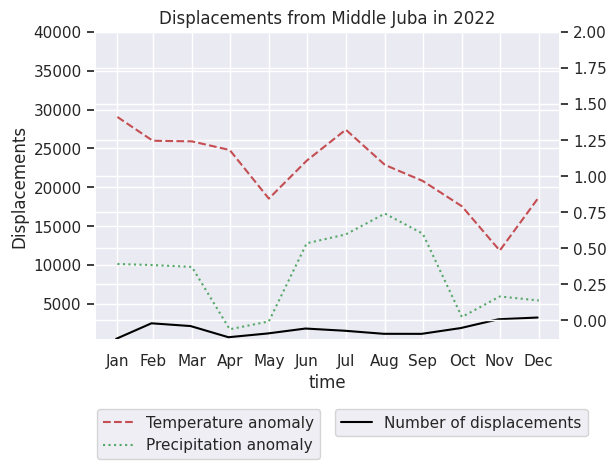

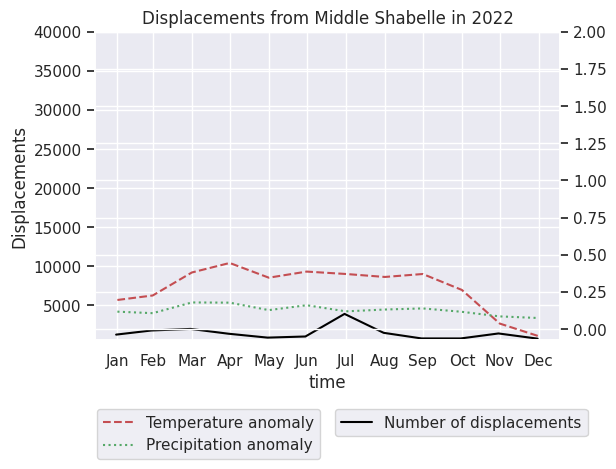

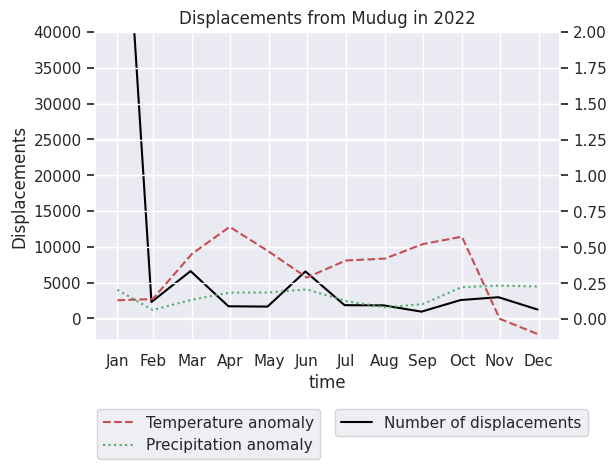

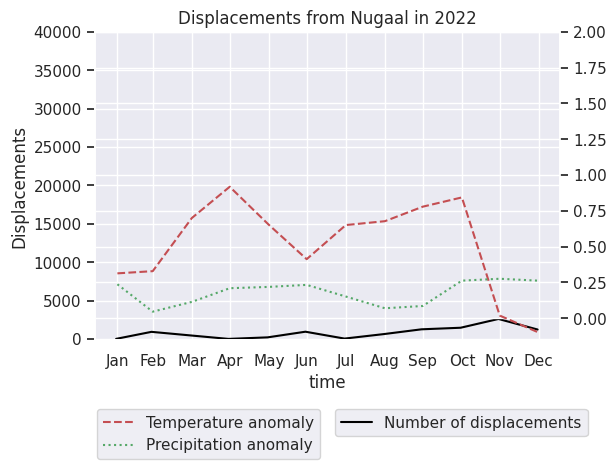

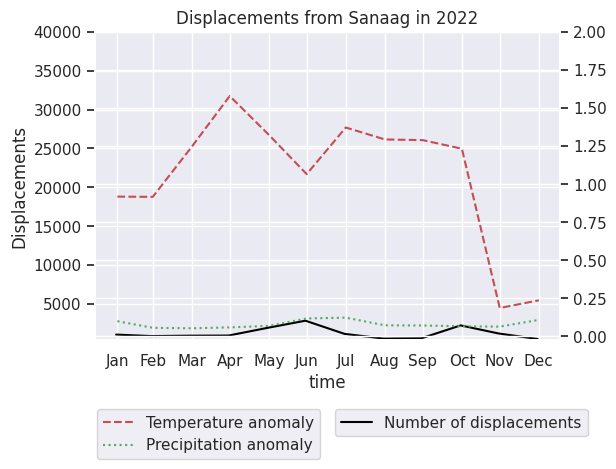

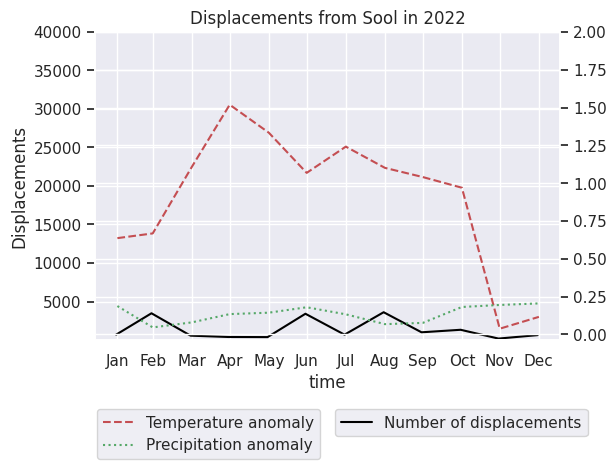

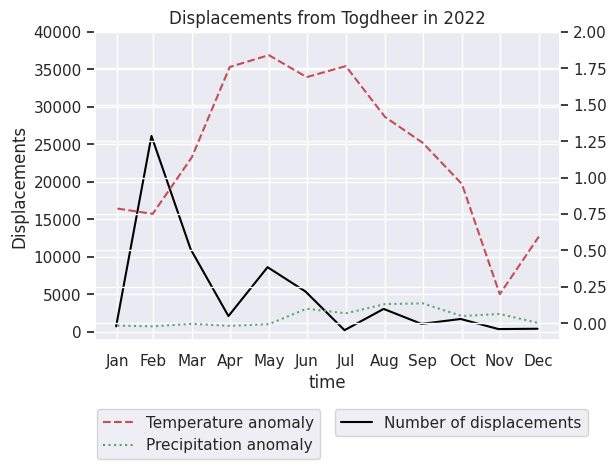

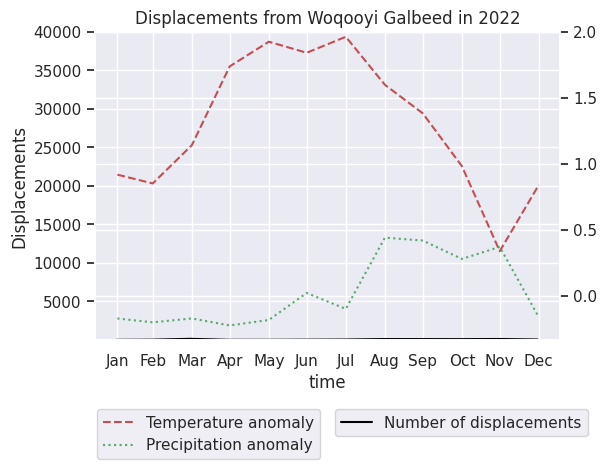

In [16]:
for origin in regions:
    
    # Filter the data for the specified region
    region_data = agg_d_22['drought'][agg_d_22['drought']['Previous (Departure) Region'] == origin]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(6, 4))
    ax2 = ax.twinx()
    #ax3 = ax.twinx()

    # Iterate over each origin and plot the time series
        
    region_data = region_data.groupby([pd.Grouper(key='time', freq='M')]).agg({'Number of Individuals': 'sum', 'Current (Arrival) District': 'first', 'Previous (Departure) District': 'first', 'Current (Arrival) Region':'first'}).reset_index()

    ax.plot(region_data['time'], region_data['Number of Individuals'], label='Number of displacements', color='black')
    ax2.plot(pd.to_datetime(df_d_22[df_d['admin1']==origin]['time'])+ pd.DateOffset(months=1), df_d_22[df_d['admin1']==origin]['TA_lag2'], color='r', linestyle='dashed', label='Temperature anomaly')
    ax2.plot(pd.to_datetime(df_d_22[df_d['admin1']==origin]['time'])+ pd.DateOffset(months=1), df_d_22[df_d['admin1']==origin]['PA_lag2'], color='g', linestyle='dotted', label='Precipitation anomaly')    

    # Set the title and labels
    ax.set_title(f"Displacements from {origin} in 2022")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    ax.set_xticks([datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1), datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1), datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),datetime(2023, 1, 1), ])
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax.set_ylim(top=40000)
    ax2.set_ylim(top=2)
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper left')
    ax2.legend(bbox_to_anchor=(0.5, -0.2), loc='upper right')
    plt.show()


### Scatter plot for 2022 only

$$
Log(Disp_{ji}) = f(\frac{TA_{lag2, i}}{dist^2_{ji}})
$$


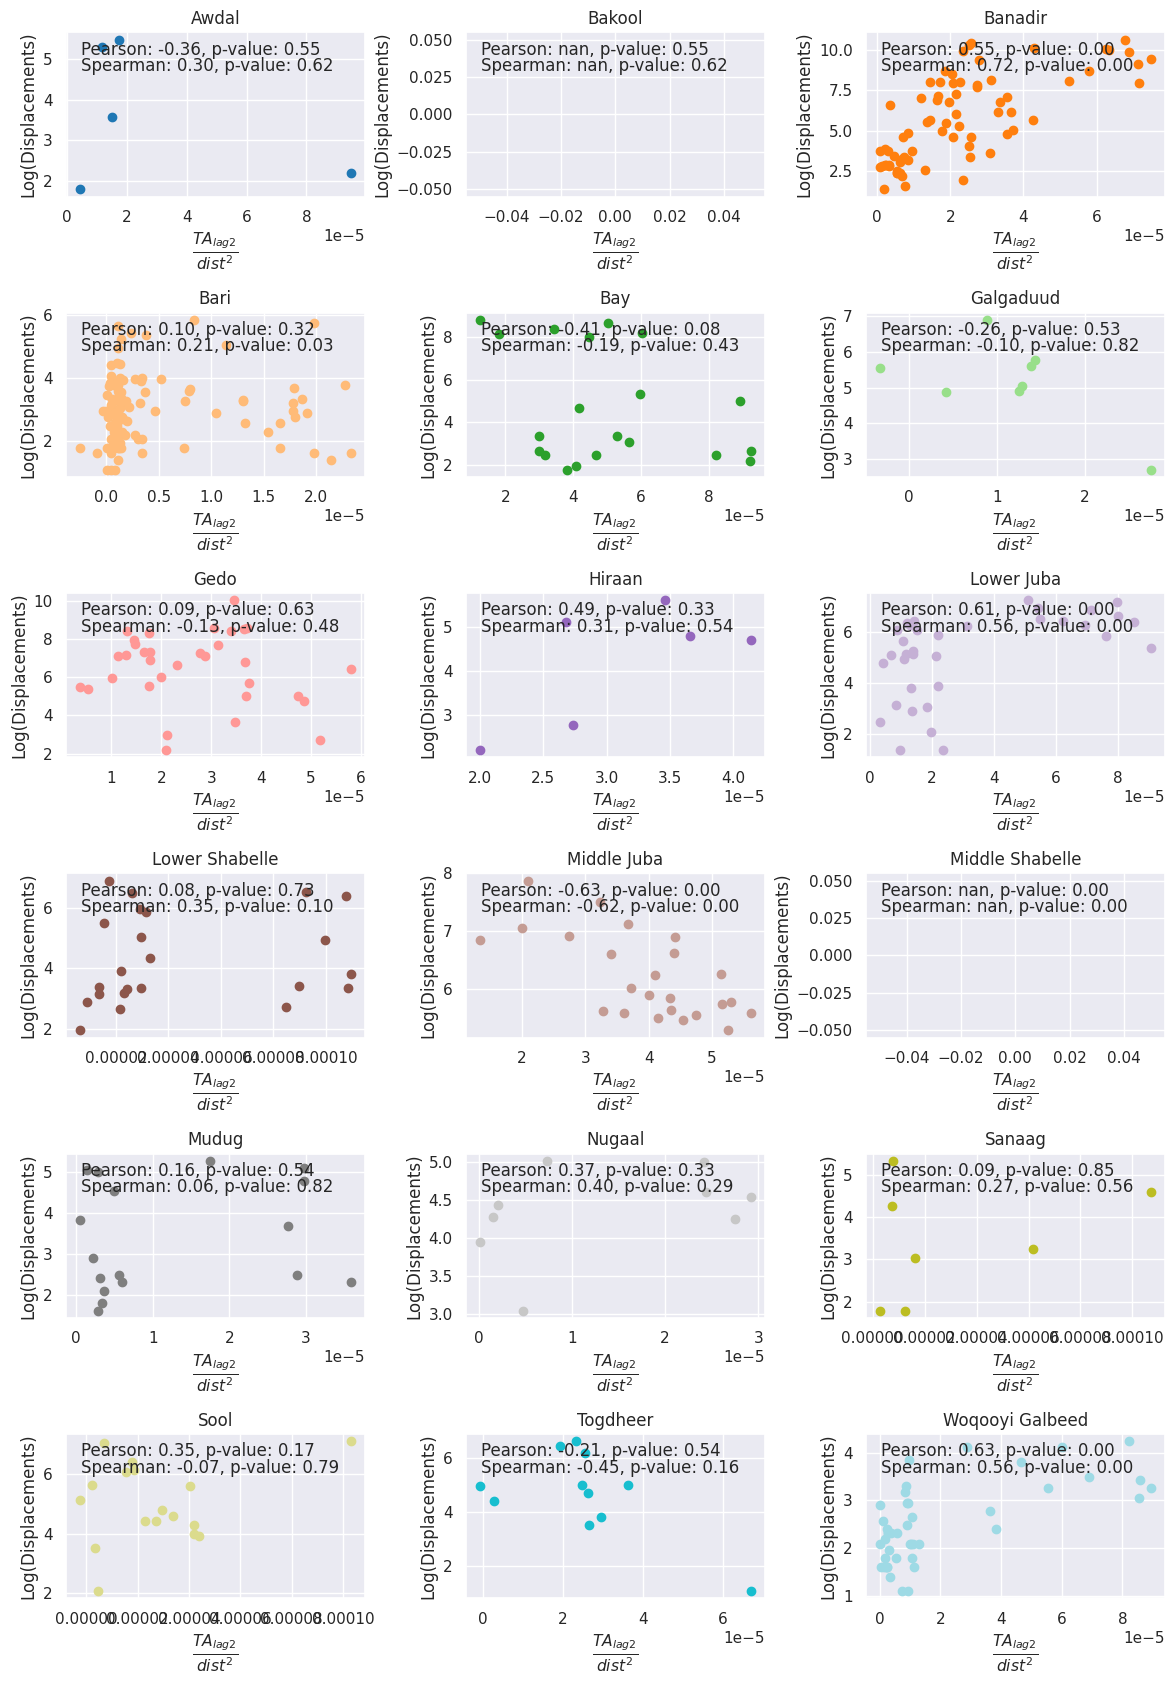

In [17]:
fig, axs = plt.subplots(6, 3, figsize=(12, 17))  

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
        
    for month in range(12):
        
        disp_reg = disp_matxs_r_22['drought'][j]
        disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
        disp_reg['inv_dist'] = inv_distance[j]
        df_m_y = df_d_22[(df_d_22['year'] == 2022) & (df_d_22['month'] == month+1)].reset_index()
        disp_reg['TA_lag2'] = df_m_y['TA_lag2']
        disp_reg = disp_reg[disp_reg[j]!=0]
        color = cmap(region_codes[regions == j][0])
        axs[row, col].scatter(disp_reg['TA_lag2']*disp_reg['inv_dist']**2, np.log(disp_reg[j]), color=color)
    
        vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['inv_dist']*df_j['TA_lag2'])]
    df_j = df_j[df_j['inv_dist']*df_j['inv_dist']*df_j['TA_lag2'] != np.nan]

    
    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan

    axs[row, col].set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$', fontsize=16)
    axs[row, col].set_ylabel('Log(Displacements)')
    axs[row, col].set_title(j)
    axs[row, col].text(0.05, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    axs[row, col].text(0.05, 0.85, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    
plt.tight_layout()
plt.show()

### Jointplot for 2022 only

$$
Log(Disp_{ji}) = f(\frac{TA_{lag2, i}}{dist^2_{ji}})
$$

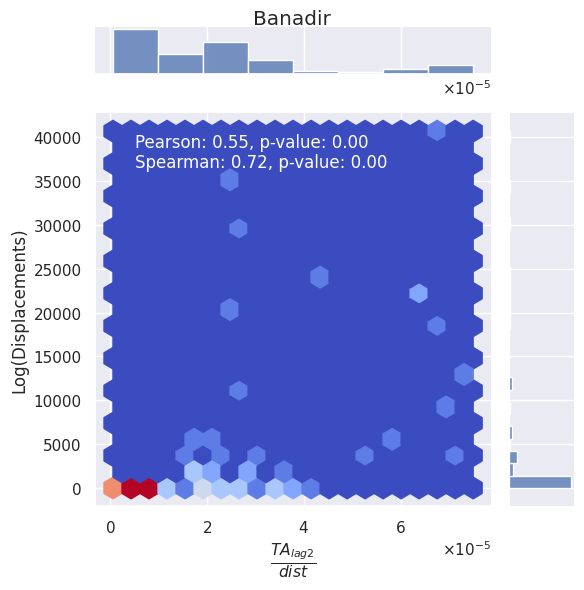

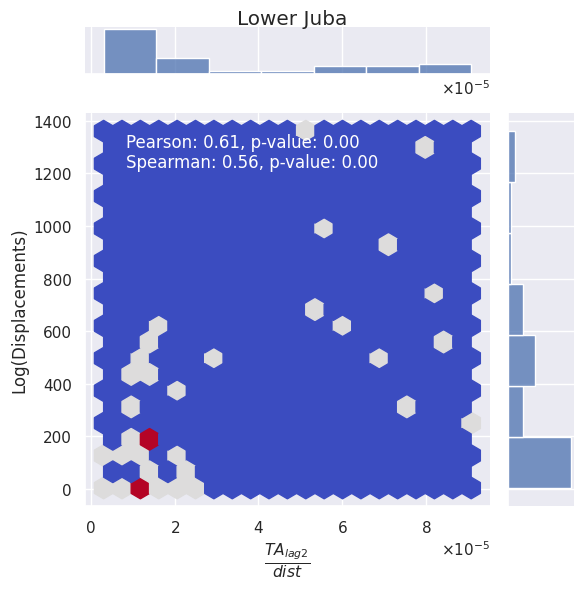

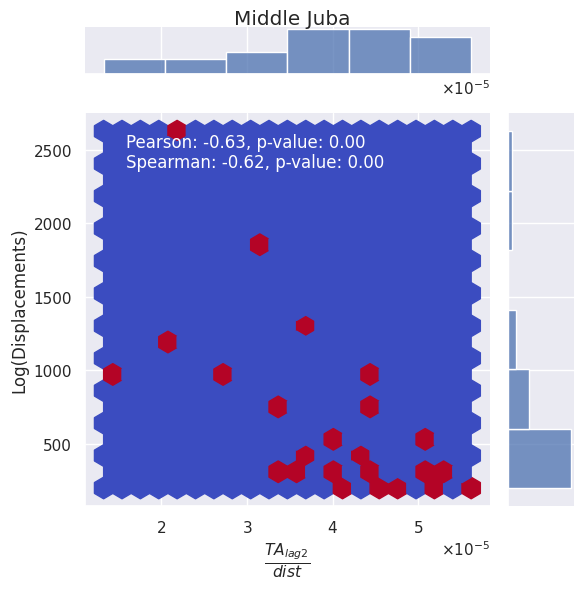

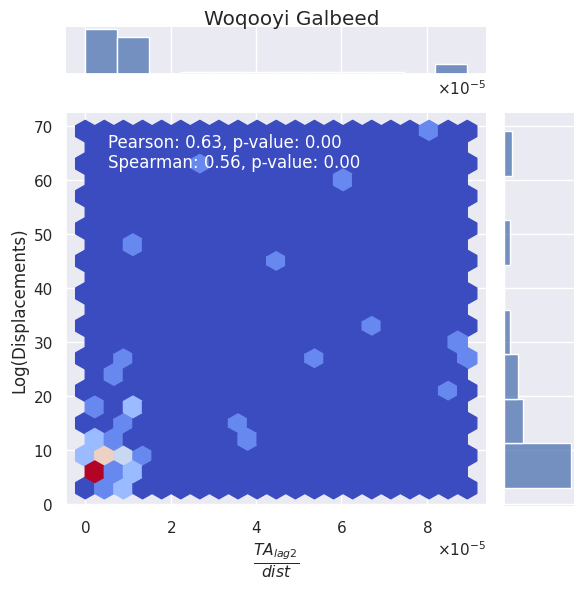

In [18]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

        
    for month in range(12):
        
        disp_reg = disp_matxs_r_22['drought'][j]
        disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
        disp_reg['inv_dist'] = inv_distance[j]
        df_m_y = df_d[(df_d['year'] == 2022) & (df_d['month'] == month+1)].reset_index()
        disp_reg['TA_lag2'] = df_m_y['TA_lag2']
        disp_reg = disp_reg[disp_reg[j]!=0]
        
        vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = df_j[j]#np.log(df_j[j])
    df_j['x'] = df_j['TA_lag2']*df_j['inv_dist']**2

    if len(df_j[j]) == 0 or p_value_p>0.05:
        continue

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 20})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)
    
plt.show()

### Heatmap Pearson and spearman coefficient, drought 2022

In [19]:
vec_corr_pearson = []
vec_corr_spearman = []
df_m_y = df_d_22.reset_index()
#df_m_y = df_m_y.drop(df_m_y.columns[-51:], axis=1)
#inv_distance.index = inv_distance.columns.tolist()

for j in regions:
    
    disp_ji = disp_matxs_r_22['drought'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd = dd[dd[j]!=0]
    dd = dd[dd['Previous (Departure) Region']!=j]
    dd['x'] = dd['TA_lag2']*dd['inv_distance']**2

    if len(dd) >= 2:
        corr_pearson, p_value_p = pearsonr(dd['x'], dd[j])
        corr_spearman, p_value_s = spearmanr(dd['x'], dd[j])
        if p_value_p<0.05:
            vec_corr_pearson.append(corr_pearson)
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_pearson.append(np.nan)
            vec_corr_spearman.append(np.nan)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')
sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

ValueError: array must not contain infs or NaNs

### Heatmap Pearson (lags) in 2022, drought displacements

#### TA

In [ ]:
vec_corr_pearson = []
vec_p_values = []

df_m_y = df_d_22.reset_index()
df_m_y = df_m_y.drop(df_m_y.columns[-51:], axis=1)
inv_distance.index = inv_distance.columns.tolist()
#disp_matxs_r_22['drought']['year'] = disp_matxs_r_22['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
            
        disp_ji = disp_matxs_r_22['drought'][j].reset_index()
        disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
        dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
        dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
        dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
        dd = dd[dd['Previous (Departure) Region']!=j]
        dd['x'] = dd['TA_lag2']*dd['inv_distance']**2

        if len(dd[j]) >= 2:
            corr_pearson, p_value = pearsonr(dd['x'], dd[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

#### DL

In [ ]:
vec_corr_pearson = []
vec_p_values = []
#disp_matxs_r_22['drought']['year'] = disp_matxs_r_22['drought'].index.get_level_values('time').year
reg_vec = ['DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
            
        disp_ji = disp_matxs_r_22['drought'][j].reset_index()
        disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
        dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
        dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
        dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
        #dd = dd[dd[j]!=0]
        dd = dd[dd['Previous (Departure) Region']!=j]
        dd['x'] = dd['DL_lag2']*dd['inv_distance']**2

        if len(dd[j]) >= 2:
            corr_pearson, p_value = pearsonr(dd['x'], dd[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

#### PA

In [ ]:
vec_corr_pearson = []
vec_p_values = []
disp_matxs_r_22['drought']['year'] = disp_matxs_r_22['drought'].index.get_level_values('time').year
reg_vec = ['PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
            
        disp_ji = disp_matxs_r_22['drought'][j].reset_index()
        disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
        dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
        dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
        dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
        #dd = dd[dd[j]!=0]
        dd = dd[dd['Previous (Departure) Region']!=j]
        dd['x'] = dd['PA_lag2']*dd['inv_distance']**2

        if len(dd[j]) >= 2:
            corr_pearson, p_value = pearsonr(dd['x']**2, dd[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

### Jointplot for Banadir region with different lags in 2022, drought

In [ ]:
j = 'Banadir'
color = cmap(region_codes[regions == j][0])

for i, lag in enumerate(vac_lag):

    vec_region = []
    df_j=[]

    disp_matxs_i = disp_matxs_r_22['drought']
    
    for month in range(12):
        
        disp_reg = disp_matxs_i[j]
        disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
        inv_distance.index = inv_distance.columns.tolist()
        disp_reg['inv_dist'] = disp_reg['Previous (Departure) Region'].map(inv_distance[j])
        df_m_y = df_d[(df_d['month'] == month+1)].reset_index()
        disp_reg[lag] = df_m_y[lag]
        disp_reg = disp_reg[disp_reg[j]!=0]
        
        vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j[lag]*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j[lag]*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.fig.set_size_inches(6, 6)
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[i]}}}{{dist^2}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

## 2020 flood

### Time Series of total flood Displacements from {origin} in 2020 with TA, PA

In [ ]:
for origin in regions:
    
    # Filter the data for the specified region
    region_data = agg_d_20['flood'][agg_d_20['flood']['Previous (Departure) Region'] == origin]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(6, 4))
    ax2 = ax.twinx()

    # Iterate over each origin and plot the time series
        
    region_data = region_data.groupby([pd.Grouper(key='time', freq='M')]).agg({'Number of Individuals': 'sum', 'Current (Arrival) District': 'first', 'Previous (Departure) District': 'first', 'Current (Arrival) Region':'first'}).reset_index()
    #df_d_22['time1']=pd.to_datetime(df_d_20['time'])
    ax.plot(region_data['time'], region_data['Number of Individuals'], label='Number of displacements', color='black')
    ax2.plot(pd.to_datetime(df_d_20[df_d_20['admin1']==origin]['time'])+ pd.DateOffset(months=1), df_d_20[df_d_20['admin1']==origin]['TA_lag2'], color='r', linestyle='dashed', label='Temperature anomaly')
    ax2.plot(pd.to_datetime(df_d_20[df_d_20['admin1']==origin]['time'])+ pd.DateOffset(months=1), df_d_20[df_d_20['admin1']==origin]['PA_lag2'], color='g', linestyle='dotted', label='Precipitation anomaly')    

    # Set the title and labels
    ax.set_title(f"Displacements from {origin} in 2022")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    #ax.set_xticks([datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1), datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1), datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),datetime(2023, 1, 1), ])
    #ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax.set_ylim(top=100000)
    ax2.set_ylim(top=2)
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper left')
    ax2.legend(bbox_to_anchor=(0.5, -0.2), loc='upper right')
    plt.show()


### Time Series of Displacements to {destination} in 2020, due to flood

In [ ]:
for destination in regions:
    
    # Filter the data for the specified region
    region_data = agg_d_20['flood'][agg_d_20['flood']['Current (Arrival) Region'] == destination]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(7, 5))

    # Iterate over each origin and plot the time series
    for origin in regions:

        region_data = region_data.groupby([pd.Grouper(key='time', freq='M'), 'Previous (Departure) Region']).agg({'Number of Individuals': 'sum', 'Current (Arrival) District': 'first', 'Previous (Departure) District': 'first'}).reset_index()
        origin_data = region_data[region_data['Previous (Departure) Region'] == origin]
        if origin_data.empty:
            continue
        ax.plot(origin_data['time'], origin_data['Number of Individuals'], label=origin)

    # Set the title and labels
    ax.set_title(f"Time Series of Displacements to {destination}")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    #ax.set_ylim(top=40000)
    #ax.set_xticks([datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1), datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1), datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),datetime(2023, 1, 1), ])
    #ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    # Set the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


### Heatmap Pearson and spearman coefficient, flood 2020

In [ ]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs_r_20['flood']['year'] = disp_matxs_r_20['flood'].index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    disp_matxs_i = disp_matxs_r_20['flood']
        
    for month in range(12):
        color = cmap(region_codes[regions == j][0])
        disp_reg = disp_matxs_i[j]
        disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
        disp_reg['inv_dist'] = inv_distance[j]
        df_m_y = df_d_20[(df_d_20['month'] == month+1)].reset_index()
        disp_reg['PA_lag2'] = df_m_y['PA_lag2']
        disp_reg = disp_reg[disp_reg[j]!=0]

        disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['PA_lag2'])]
    #if df_j contains nan values, then skip
    

    if (len(df_j[j]) >= 2) and (not(df_j.isnull().values.any())):
        corr_pearson, p_value_p = pearsonr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])

        if p_value_p<0.05:
            vec_corr_pearson.append(corr_pearson)
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_pearson.append(np.nan)
            vec_corr_spearman.append(np.nan)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

### Heatmap Pearson and Spearman (lags) in 2020, flood displacements

In [ ]:
vec_corr_pearson = []
vec_p_values = []
reg_vec = ['PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
            
        disp_ji = disp_matxs_r_20['flood'][j].reset_index()
        disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
        dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
        dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
        dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
        #dd = dd[dd[j]!=0]
        dd = dd[dd['Previous (Departure) Region']!=j]
        dd['x'] = dd['PA_lag2']*dd['inv_distance']**2

        if len(dd[j]) >= 2:
            corr_pearson, p_value = pearsonr(dd['x']**2, dd[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

In [ ]:
disp_matxs_r_20['flood']

## 2021 conflict

### Heatmap Pearson and spearman coefficient, conflict 2021

In [ ]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs_r_21['conflict']['year'] = disp_matxs_r_21['conflict'].index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    disp_matxs_i = disp_matxs_r_21['drought']
        
    for month in range(12):
        color = cmap(region_codes[regions == j][0])
        disp_reg = disp_matxs_i[j]
        disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
        disp_reg['inv_dist'] = inv_distance[j]
        df_m_y = df_d_21[(df_d_21['month'] == month+1)].reset_index()
        disp_reg['conflict'] = df_m_y['conflicts']
        disp_reg = disp_reg[disp_reg[j]!=0]

        disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['conflict'])]

    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j['conflict']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['conflict']*df_j['inv_dist']**2, df_j[j])

        if p_value_p<0.05:
            vec_corr_pearson.append(corr_pearson)
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_pearson.append(np.nan)
            vec_corr_spearman.append(np.nan)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
vec_corr_spearman = []
vec_p_values = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
            
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_r_22['drought'][j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d_22[(df_d_22['year'] == year) & (df_d_22['month'] == month+1)].reset_index()
            disp_reg['TA_lag_n'] = df_m_y[TA_lag]
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_spearman, p_value = spearmanr(df_j['inv_dist']*df_j['TA_lag_n'], df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_spearman.append(corr_spearman)
            else:
                vec_corr_spearman.append(np.nan)
        else:
            vec_corr_spearman.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Spearman Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

### Jointplot for Banadir region in 2021, conflicts

In [ ]:
j = 'Banadir'
color = cmap(region_codes[regions == j][0])
lag= 'conflicts'


vec_region = []
df_j=[]

disp_matxs_i = disp_matxs_r_21['conflict']

for month in range(12):
    
    disp_reg = disp_matxs_i[j]
    disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
    disp_reg['inv_dist'] = inv_distance[j]
    df_m_y = df_d_21[(df_d_21['month'] == month+1)].reset_index()
    disp_reg[lag] = df_m_y[lag]
    disp_reg = disp_reg[disp_reg[j]!=0]
    
    vec_region.append(disp_reg)

df_j = pd.concat(vec_region, ignore_index=True)
df_j = df_j[np.isfinite(df_j[lag]*df_j['inv_dist']**2)]

if len(df_j[j]) >= 2:
    corr_pearson, p_value_p = pearsonr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
    corr_spearman, p_value_s = spearmanr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
else:
    corr_pearson = np.nan
    corr_spearman = np.nan
df_j[j] = np.log(df_j[j])
df_j['x'] = df_j[lag]*df_j['inv_dist']**2

g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
g.fig.set_size_inches(6, 6)
g.ax_joint.set_xlabel(fr'$\frac{{conflicts}}{{dist^2}}$', fontsize=16)
g.ax_joint.set_ylabel('Log(Displacements)')
g.fig.suptitle(j)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
g.ax_joint.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

## Heatmap Pearson and Spearman (lags) in 2017

In [ ]:
vec_corr_pearson = []
vec_p_values = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
            
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_r_17['drought'][j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d_17[(df_d_17['month'] == month+1)].reset_index()
            disp_reg['TA_lag_n'] = df_m_y[TA_lag]
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['TA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

## Banadir csv

In [ ]:
j = 'Banadir'
disp_ji = disp_matxs_r_22['drought'][j].reset_index()
disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')

df_m_y = df_d.reset_index()
dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
inv_distance.index = inv_distance.columns.tolist()
#inv_distance.index.name = 'index'
dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)

dd = dd[dd['Previous (Departure) Region']!=j]
dd['log_disp_ban']= np.log(dd['Banadir'])
dd['x'] = dd['TA_lag2']*dd['inv_distance']**2
dd['x_dist'] = dd['TA_lag2']*dd['inv_distance']
dd['inv_distance_2']=dd['inv_distance']**2

#dd = pd.merge(dd,gdp_access,how='left',left_on=['Previous (Departure) Region'],right_on=['shapeName'])
#dd=pd.merge(dd,pop_density,how='left',left_on=['year','Previous (Departure) Region'],right_on=['year','admin1'])

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
gdp_access = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/GDP.csv")
gdp_access['shapeName'].replace({'Hiiraan':'Hiraan','Lower Shebelle':'Lower Shabelle','Middle Shebelle':'Middle Shabelle'}, inplace=True)
gdp_access = gdp_access[['gdp_grid.none.mean','accessibility_to_cities_2015_v1.0.mean','shapeName']]
gdp_access.rename(columns={'gdp_grid.none.mean':'gdp_mean','accessibility_to_cities_2015_v1.0.mean':'accessibility_to_cities_mean'}, inplace=True)

dd = pd.merge(dd,gdp_access,how='left',left_on=['Previous (Departure) Region'],right_on=['shapeName'])

dd['gdp_pp_destination'] = dd['gdp_mean']/dd['population_density']

KeyError: 'population_density'

In [ ]:
dd_log = dd.copy()
dd_log['Disp_log1'] = np.log(dd_log['Banadir']+1)

#dd = dd[np.isfinite(dd['Disp_log'])]
dd = dd[dd['Banadir']!=0]
dd['Disp_log'] = np.log(dd['Banadir'])

col1=['TA','PA', 'DL', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5',
       'TA_lag6', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5',
       'PA_lag6', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5',
       'DL_lag6', 'conflicts', 'inv_distance', 'inv_distance_2',
       'sum_disp', 'population_density', 'x',
       'x_dist', 'gdp_mean','Disp_log',
       'accessibility_to_cities_mean', 'gdp_pp_destination']
min_max_scaler = MinMaxScaler().fit(dd[col1])
dd[col1] = min_max_scaler.transform(dd[col1])

#min_max_scaler = MinMaxScaler().fit(dd_log[col1])
#dd_log[col1] = min_max_scaler.transform(dd_log[col1])

/tmp/ipykernel_15204/1260508440.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['Disp_log'] = np.log(dd['Banadir'])


KeyError: "['population_density', 'gdp_pp_destination'] not in index"

In [ ]:
dd.to_csv('csv/dd_ban_norm.csv')

## fit and predict

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

predictions = []

for yr in range(2016, 2023):
    disp_matxs_r_yr = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == yr]
    df_d_yr = df_d[df_d['year'] == yr]
    j = 'Banadir'
    disp_ji = disp_matxs_r_yr[j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')

    df_m_y = df_d_yr.reset_index()
    dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    inv_distance.index = inv_distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd = dd[dd['Previous (Departure) Region'] != j]
    dd['log_disp'] = np.log(dd['Banadir'])
    dd['x'] = dd['TA_lag2'] * dd['inv_distance'] ** 2
    dd['inv_distance_2'] = dd['inv_distance'] ** 2

    # Filter out invalid or extreme values
    dd = dd[np.isfinite(dd['log_disp'])]
    dd = dd[np.isfinite(dd['x'])]

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(dd[['x']], dd['log_disp'])

    # Predict the log displacements for Banadir
    predictions.append(model.predict(dd[['x']]))

    # Plot the scatter plot with the regression line
    plt.scatter(x=dd['x'], y=dd['log_disp'], c=dd['inv_distance_2'], cmap='coolwarm', s=50, alpha=0.5)
    plt.plot(dd['x'], model.predict(dd[['x']]), color='red', linewidth=2)
    plt.title(f'Year {yr}')
    plt.xlabel(fr'$\frac{{TAlag2}}{{dist^2}}$')
    plt.ylabel('Log(Displacements)')
    plt.colorbar().set_label('Inverse Distance Squared')
    #save as pdf file
    plt.savefig(f'banadir_{yr}.pdf')
    plt.show()

In [ ]:
from scipy.stats import pearsonr

predictions = []
pearson_coeffs = []
p_values = []

for yr in range(2016, 2023):
    disp_matxs_r_yr = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == yr]
    df_d_yr = df_d[df_d['year'] == yr]
    j = 'Banadir'
    disp_ji = disp_matxs_r_yr[j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')

    df_m_y = df_d_yr.reset_index()
    dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    inv_distance.index = inv_distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd = dd[dd['Previous (Departure) Region'] != j]
    dd['log_disp'] = np.log(dd['Banadir'])
    dd['x'] = dd['TA_lag2'] * dd['inv_distance'] ** 2
    dd['inv_distance_2'] = dd['inv_distance'] ** 2

    # Filter out invalid or extreme values
    dd = dd[np.isfinite(dd['log_disp'])]
    dd = dd[np.isfinite(dd['x'])]

    # Compute the Pearson correlation coefficient and its p-value
    pearson_coeff, p_value = pearsonr(dd['x'], dd['log_disp'])
    pearson_coeffs.append(pearson_coeff)
    p_values.append(p_value)

# Plot the Pearson correlation coefficient and its p-value
plt.plot(range(2016, 2023), pearson_coeffs, marker='o', label='Pearson Coefficient')
plt.plot(range(2016, 2023), p_values, marker='o', label='p-value')
plt.title('Pearson Coefficient and p-value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import pearsonr

predictions = []

for yr in range(2016, 2023):
    disp_matxs_r_yr = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == yr]
    df_d_yr = df_d[df_d['year'] == yr]
    j = 'Banadir'
    disp_ji = disp_matxs_r_yr[j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')

    df_m_y = df_d_yr.reset_index()
    dd = disp_ji.merge(df_m_y, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    inv_distance.index = inv_distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd = dd[dd['Previous (Departure) Region'] != j]
    dd['log_disp'] = np.log(dd['Banadir'])
    dd['x'] = dd['TA_lag2'] * dd['inv_distance'] ** 2
    dd['inv_distance_2'] = dd['inv_distance'] ** 2

    # Filter out invalid or extreme values
    dd = dd[np.isfinite(dd['log_disp'])]
    dd = dd[np.isfinite(dd['x'])]

    # Compute the Pearson correlation coefficient and its p-value
    pearson_coeff, p_value = pearsonr(dd['x'], dd['log_disp'])

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(dd[['x']], dd['log_disp'])

    # Predict the log displacements for Banadir
    predictions.append(model.predict(dd[['x']]))

    # Plot the scatter plot with the regression line
    plt.scatter(x=dd['x'], y=dd['log_disp'], c=dd['inv_distance_2'], cmap='coolwarm', s=50, alpha=0.5)
    plt.plot(dd['x'], model.predict(dd[['x']]), color='red', linewidth=2)
    plt.title(f'Year {yr}')
    plt.xlabel(fr'$\frac{{TAlag2}}{{dist^2}}$')
    plt.ylabel('Log(Displacements)')
    plt.colorbar().set_label('Inverse Distance Squared')
    #plt.xlim(left=-0.00001, right=0.0001)
    plt.ylim(bottom=0, top=12)
    # Add text for Pearson coefficient and p-value
    plt.text(0.05, 0.95, f'Pearson Coefficient: {pearson_coeff:.2f}', transform=plt.gca().transAxes, va='top')
    plt.text(0.05, 0.88, f'p-value: {p_value:.2f}', transform=plt.gca().transAxes, va='top')
    # Add text for the slope of the regression line
    plt.text(0.05, 0.81, f'Slope: {model.coef_[0]:.2f}', transform=plt.gca().transAxes, va='top')

    plt.show()

# Plot the Pearson correlation coefficient and its p-value
plt.plot(range(2016, 2023), pearson_coeffs, marker='o', label='Pearson Coefficient')
plt.plot(range(2016, 2023), p_values, marker='o', label='p-value')
plt.title('Pearson Coefficient and p-value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

# Concatenate each destination 

In [8]:
# DROUGHT all y

vec_d=[]
for j in regions:
    
    disp_ji = disp_matxs_r['drought'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    dd = dd.merge(df_d[df_d["admin1"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    inv_distance.index = inv_distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    #dd = dd[dd[j]!=0]
    dd = dd[dd['Previous (Departure) Region']!=j]
    #dd['x_t'] = dd['TA_lag2']*dd['inv_distance']**2
    #dd['x_p'] = dd['PA_lag2']*dd['inv_distance']**2
    #dd['x_p_dist'] = dd['TA_lag2']*dd['inv_distance']
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) Region',
       'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'population_density_dep',
       'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr', 'population_density_arr', 'inv_distance'],
       value_vars=[j], var_name='Current (Arrival) Region', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc['Disp_log'] = np.log(df_conc['Displacements'])
df_conc['inv_distance_2'] = df_conc['inv_distance']**2

df_conc.rename(columns={'year_dep':'year'}, inplace=True)

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# CONFLICTS all

vec_d=[]
for j in regions:
    
    disp_ji = disp_matxs_r['conflict'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    dd = dd.merge(df_d[df_d["admin1"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    inv_distance.index = inv_distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    #dd = dd[dd[j]!=0]
    dd = dd[dd['Previous (Departure) Region']!=j]
    #dd['x_t'] = dd['TA_lag2']*dd['inv_distance']**2
    #dd['x_p'] = dd['PA_lag2']*dd['inv_distance']**2
    #dd['x_p_dist'] = dd['TA_lag2']*dd['inv_distance']
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) Region',
       'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'population_density_dep',
       'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr', 'population_density_arr', 'inv_distance'],
       value_vars=[j], var_name='Current (Arrival) Region', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc['Disp_log'] = np.log(df_conc['Displacements'])
df_conc['inv_distance_2'] = df_conc['inv_distance']**2

df_conc.rename(columns={'year_dep':'year'}, inplace=True)

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
ban= dd[dd['admin1']=='Banadir']
#plot the time series of ban['TA']
fig, ax = plt.subplots(figsize=(6, 4))
ax2 = ax.twinx()
ax.plot(pd.to_datetime(ban['time']), ban['Banadir'], label='Number of displacements', color='black')
ax2.plot(pd.to_datetime(ban['time']), ban['TA'], color='r', linestyle='dashed', label='Temperature anomaly')
ax2.plot(pd.to_datetime(ban['time']), ban['PA'], color='g', linestyle='dotted', label='Precipitation anomaly')
ax.set_title(f"Displacements from Bay in 2022")
ax.set_xlabel("time")
ax.set_ylabel("Displacements")

## GDP, pop_density and accessibility to cities

In [16]:
#df_conc = pd.merge(df_conc,pop_density,how='left',left_on=['year','Current (Arrival) Region'],right_on=['year','admin1'], suffixes=('_origin', '_destination'))
#df_conc = pd.merge(df_conc,pop_density,how='left',left_on=['year','Current (Arrival) Region'],right_on=['year','admin1'])
#df_conc = pd.merge(df_conc,pop_density,how='left',left_on=['year','Previous (Departure) Region'],right_on=['year','admin1'], suffixes=('_destination', '_origin'))

#df_conc.drop(['admin1_origin','admin1_destination'], axis=1, inplace=True)

gdp_access = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/GDP.csv")
gdp_access['shapeName'].replace({'Hiiraan':'Hiraan','Lower Shebelle':'Lower Shabelle','Middle Shebelle':'Middle Shabelle'}, inplace=True)
gdp_access = gdp_access[['gdp_grid.none.mean','accessibility_to_cities_2015_v1.0.mean','shapeName']]
gdp_access.rename(columns={'gdp_grid.none.mean':'gdp_mean','accessibility_to_cities_2015_v1.0.mean':'accessibility_to_cities_mean'}, inplace=True)

df_conc = pd.merge(df_conc,gdp_access,how='left',left_on=['Current (Arrival) Region'],right_on=['shapeName'])
df_conc = pd.merge(df_conc,gdp_access,how='left',left_on=['Previous (Departure) Region'],right_on=['shapeName'], suffixes=('_arr', '_dep'))
df_conc.drop(['shapeName_dep','shapeName_arr'], axis=1, inplace=True)

In [17]:
#create new dataframe with same columns of df_conc but with df_conc['Disp_log'] updated
#df_conc_log = df_conc.copy()
#df_conc_log['Disp_log'] = np.log(df_conc_log['Displacements']+1)

df_conc = df_conc[np.isfinite(df_conc['Disp_log'])]

## Normalization

In [18]:
col=['TA','PA', 'DL', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5',
       'TA_lag6', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5',
       'PA_lag6', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5',
       'DL_lag6', 'population_density_origin', 'population_density_destination',  'conflicts', 'conflicts_lag1', 'conflicts_lag2',
       'conflicts_lag3', 'conflicts_lag4', 'conflicts_lag5', 'conflicts_lag6', 'inv_distance', 'inv_distance_2',
       'x_t', 'x_p', 'x_p_dist', 'Displacements', 'Disp_log',
        'gdp_mean_destination', 'gdp_mean_origin',
       'accessibility_to_cities_mean_destination', 'gdp_mean_origin',
       'accessibility_to_cities_mean_origin']
col1 = ['tmx_dep', 'pre_dep', 'conflicts_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'population_density_dep',
       'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr', 'population_density_arr',  'gdp_mean_dep', 'gdp_mean_arr',
       'inv_distance','inv_distance_2']

In [19]:
min_max_scaler = MinMaxScaler().fit(df_conc[col1])
df_conc[col1] = min_max_scaler.transform(df_conc[col1])

In [20]:
#df_conc.to_csv('csv/df_new_all_c.csv')

In [66]:
df_conc.columns

Index(['time', 'Previous (Departure) Region', 'admin1_dep', 'tmx_dep',
       'pre_dep', 'conflicts_dep', 'year', 'TA_dep', 'PA_dep', 'DL_dep',
       'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep',
       'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep',
       'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep',
       'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep',
       'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep',
       'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep',
       'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep',
       'population_density_dep', 'admin1_arr', 'tmx_arr', 'pre_arr',
       'conflicts_arr', 'year_arr', 'TA_arr', 'PA_arr', 'DL_arr',
       'TA_lag1_arr', 'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr',
       'TA_lag5_arr', 'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr',
       'PA_lag3_arr', 'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr',
       'DL_lag1_arr', 'DL_lag2_arr', 'DL_lag3_arr', '

# Equations

$$
Log(Disp_{ij}) = c + \beta_{1} * \frac{TA_{lag2, i}}{dist^2_{ij}} + \beta_{1} * TA_{lag2, i} +  \beta_{1}  * PA_{lag2, i}  + \beta_{1} * DL_{lag2, i}  + \beta_{1} * \frac{1}{dist_{ij}} + \beta_{1} * \frac{1}{dist^2_{ij}} + \beta_{1} * Conflicts_i + \beta_{1} * PopDensity_i + \beta_{1} * PopDensity_j  + \beta_{1} * GDPmean_i + \beta_{1}  * GDPmean_j 
$$

\begin{split}
Log(Disp_{ij}) &= \beta_{1} * \frac{TA_{lag2, i}}{dist^2_{ij}} + \beta_{2} * TA_{lag2, i} +  \beta_{3}  * PA_{lag2, i} + \beta_{4} * DL_{lag2, i}  + \beta_{5} * \frac{1}{dist_{ij}} + \beta_{7} * Conflicts_i + \gamma_j + \theta_t  + \epsilon_{jt}
\end{split}

\begin{split}
Log(Disp_{ij}) &= \alpha + \beta_{1} * \frac{TA_{lag2, i}}{dist^2_{ij}} + \beta_{2} * TA_{lag2, i} +  \beta_{3}  * PA_{lag2, i} + \beta_{4} * DL_{lag2, i}  + \beta_{5} * \frac{1}{dist_{ij}} + \beta_{6} * \frac{1}{dist^2_{ij}} +  \\ &  + \beta_{7} * Conflicts_i + \beta_{8} * PopDensity_i + \beta_{9} * PopDensity_j  + \beta_{10} * GDPmean_i + \beta_{11}  * GDPmean_j 
\end{split}